<a href="https://colab.research.google.com/github/juniismai02/kanker-kulit-tf-vggnet-mobilenet-juniismail/blob/main/Tesis_JuniIsmail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Penerapan Transfer Learning Dengan Kombinasi Arsitektur VGGnet Dan Mobilenet
Untuk Klasifikasi 7 Kategori Kanker Kulit
"""

# ======================================================
# Bagian 1: Import Libraries dan Konfigurasi Awal
# ======================================================

# Import dependencies
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Cek GPU dan mengaktifkan mixed precision untuk akselerasi
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, " Type:", gpu.device_type)

# Aktifkan mixed precision untuk mempercepat training jika GPU tersedia
if len(gpus) > 0:
    print("Enabling mixed precision training")
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print('Compute dtype: %s' % tf.keras.mixed_precision.global_policy().compute_dtype)
    print('Variable dtype: %s' % tf.keras.mixed_precision.global_policy().variable_dtype)

# Mengatur parameter yang dioptimasi
IMG_SIZE = 224  # Ukuran yang optimal untuk VGG16 dan MobileNet
BATCH_SIZE = 16  # Batch size yang sesuai untuk memori GPU
EPOCHS = 150  # Lebih banyak epoch dengan early stopping yang dioptimasi
TARGET_SAMPLES = 500  # Jumlah sample yang lebih kecil per kelas karena menggunakan 7 kelas

# Path untuk Google Colab
DATASET_DIR_1 = '/content/skin-cancer-data/HAM10000_images_part_1/'
DATASET_DIR_2 = '/content/skin-cancer-data/HAM10000_images_part_2/'
metadata_path = '/content/skin-cancer-data/HAM10000_metadata.csv'

TensorFlow version: 2.18.0
Num GPUs Available:  1
Name: /physical_device:GPU:0  Type: GPU
Enabling mixed precision training
Compute dtype: float16
Variable dtype: float32


In [ ]:
# ======================================================
# Bagian 2: Download Dataset dan Persiapan Data
# ======================================================

# Fungsi untuk mengunduh dataset
def download_dataset():
    if not os.path.exists('/content/skin-cancer-data'):
        print("Dataset tidak ditemukan. Mengunduh dataset...")
        # Membuat direktori
        os.makedirs('/content/skin-cancer-data', exist_ok=True)

        # Download dataset menggunakan Kaggle API
        try:
            # Install Kaggle API
            import subprocess
            subprocess.run(["pip", "install", "-q", "kaggle"], check=True)

            # Buat direktori dan file konfigurasi Kaggle
            os.makedirs('/root/.kaggle', exist_ok=True)
            with open('/root/.kaggle/kaggle.json', 'w') as f:
                f.write('{"username":"juniismail","key":"d5034f3351b20d2c3e93d9e017f79574"}')
            os.chmod('/root/.kaggle/kaggle.json', 0o600)

            # Unduh dataset
            subprocess.run(["kaggle", "datasets", "download", "-d", "kmader/skin-cancer-mnist-ham10000", "--path", "/content"], check=True)
            subprocess.run(["unzip", "-q", "/content/skin-cancer-mnist-ham10000.zip", "-d", "/content/skin-cancer-data"], check=True)
            print("Dataset berhasil diunduh dan diekstrak.")
        except Exception as e:
            print(f"Error saat mengunduh dataset: {e}")
            print("Silakan unduh dataset secara manual.")
    else:
        print("Dataset sudah ada.")

# Download dataset dan load data
download_dataset()

# Periksa keberadaan file dan direktori
print(f"Metadata path exists: {os.path.exists(metadata_path)}")
print(f"Dataset dir 1 exists: {os.path.exists(DATASET_DIR_1)}")
print(f"Dataset dir 2 exists: {os.path.exists(DATASET_DIR_2)}")

# Baca metadata
df = pd.read_csv(metadata_path)
print("Dataset shape:", df.shape)
print(df.head())

# Fungsi untuk mendapatkan path gambar lengkap
def get_full_image_path(filename):
    path_1 = os.path.join(DATASET_DIR_1, filename+'.jpg')
    path_2 = os.path.join(DATASET_DIR_2, filename+'.jpg')

    if os.path.exists(path_1):
        return path_1
    elif os.path.exists(path_2):
        return path_2
    else:
        return None

# Buat kolom image_path
df['image_path'] = df['image_id'].apply(get_full_image_path)

# Periksa hasil
print(f"Jumlah path gambar yang valid: {df['image_path'].notna().sum()}")
print(f"Contoh path gambar: {df['image_path'].iloc[0]}")

# Hapus baris dengan path gambar yang tidak valid
df = df.dropna(subset=['image_path'])
print(f"Dataset shape setelah menghapus path invalid: {df.shape}")

Dataset tidak ditemukan. Mengunduh dataset...
Dataset berhasil diunduh dan diekstrak.
Metadata path exists: True
Dataset dir 1 exists: True
Dataset dir 2 exists: True
Dataset shape: (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Jumlah path gambar yang valid: 10015
Contoh path gambar: /content/skin-cancer-data/HAM10000_images_part_1/ISIC_0027419.jpg
Dataset shape setelah menghapus path invalid: (10015, 8)



Kelas unik: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Jumlah sampel kelas akiec: 327
Jumlah sampel kelas bcc: 514
Jumlah sampel kelas bkl: 1099
Jumlah sampel kelas df: 115
Jumlah sampel kelas mel: 1113
Jumlah sampel kelas nv: 6705
Jumlah sampel kelas vasc: 142

Deskripsi dan jumlah sampel tiap kelas:
- akiec: Actinic Keratosis (Keratosis Aktis) - 327 sampel
- bcc: Basal Cell Carcinoma (Karsinoma Sel Basal) - 514 sampel
- bkl: Benign Keratosis (Keratosis Jinak) - 1099 sampel
- df: Dermatofibroma - 115 sampel
- mel: Melanoma - 1113 sampel
- nv: Melanocytic Nevi (Tahi Lalat) - 6705 sampel
- vasc: Vascular Lesions (Lesi Vaskular) - 142 sampel


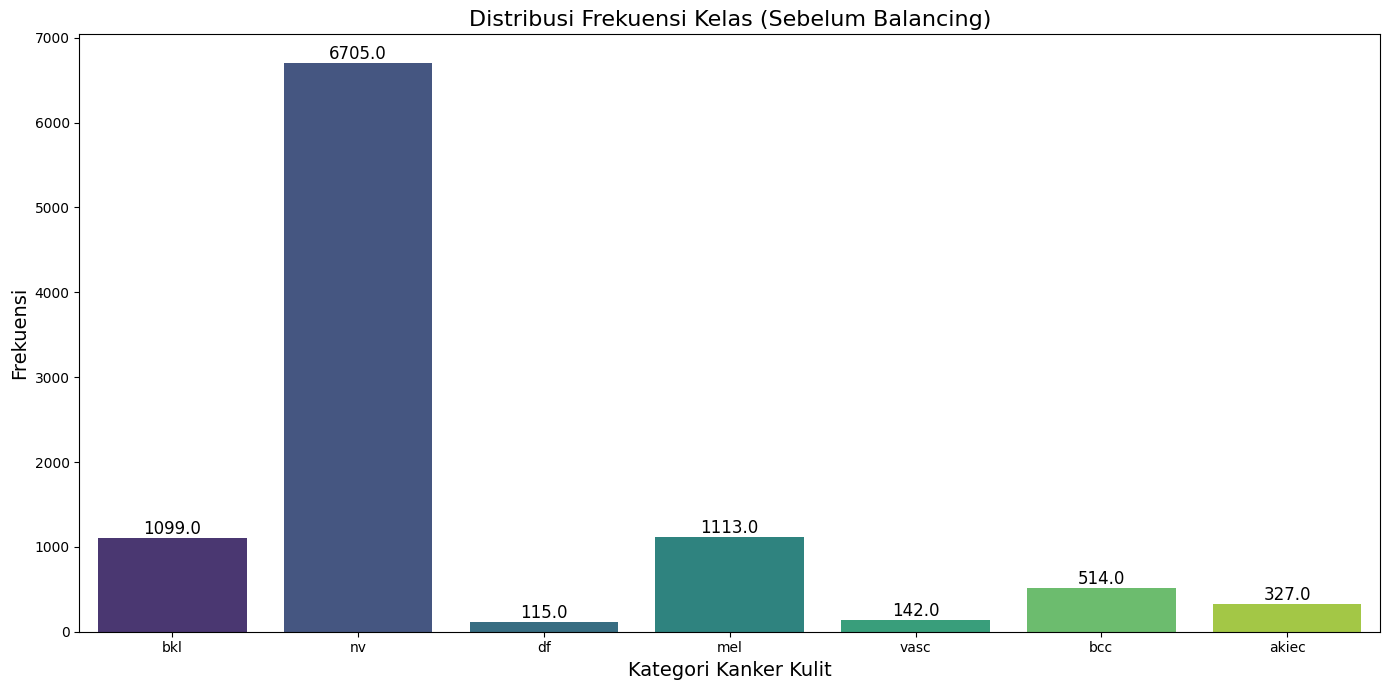


Pendekatan balancing data untuk semua 7 kelas...
Target sampel per kelas: 230
Balanced dataset shape: (1610, 8)

Distribusi Kelas Setelah Balancing:
Jumlah sampel kelas akiec setelah balancing: 230
Jumlah sampel kelas bcc setelah balancing: 230
Jumlah sampel kelas bkl setelah balancing: 230
Jumlah sampel kelas df setelah balancing: 230
Jumlah sampel kelas mel setelah balancing: 230
Jumlah sampel kelas nv setelah balancing: 230
Jumlah sampel kelas vasc setelah balancing: 230


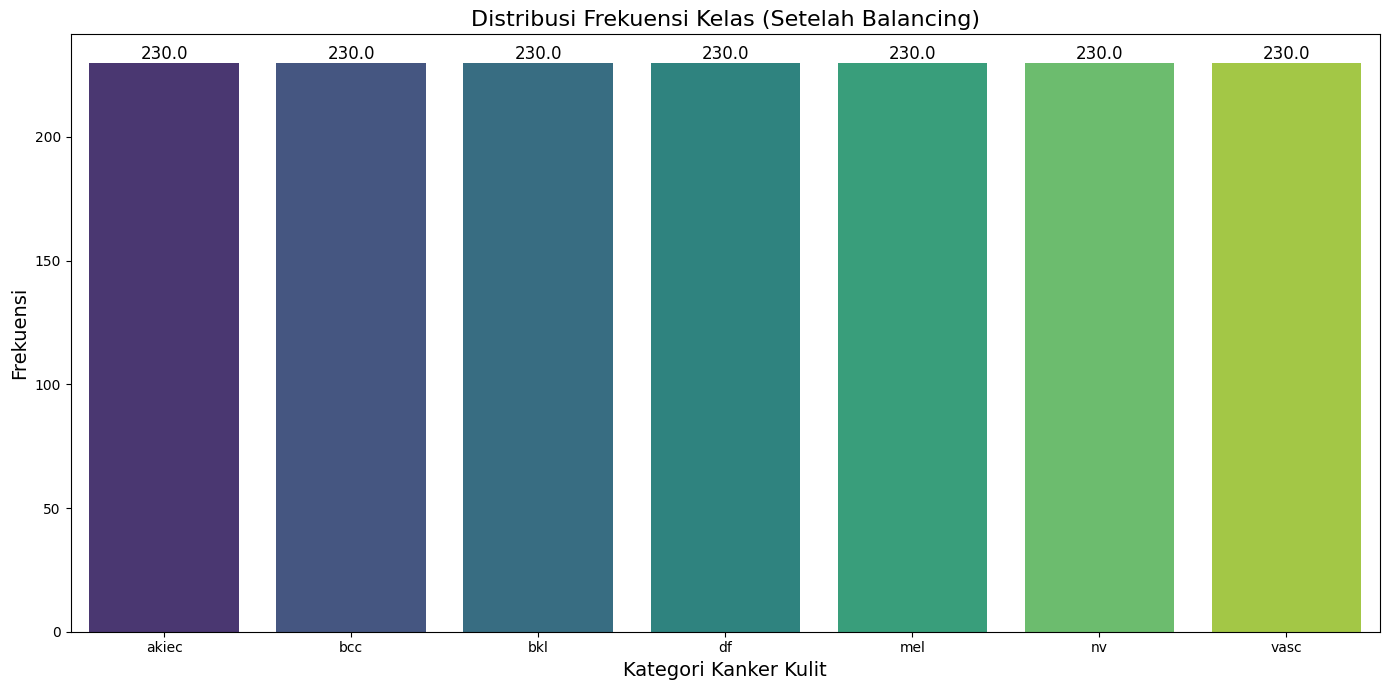

Train set size: 1288, Validation set size: 322

Distribusi Kelas Pada Train Set:
Jumlah sampel kelas akiec: 184
Jumlah sampel kelas bcc: 184
Jumlah sampel kelas bkl: 184
Jumlah sampel kelas df: 184
Jumlah sampel kelas mel: 184
Jumlah sampel kelas nv: 184
Jumlah sampel kelas vasc: 184

Distribusi Kelas Pada Validation Set:
Jumlah sampel kelas akiec: 46
Jumlah sampel kelas bcc: 46
Jumlah sampel kelas bkl: 46
Jumlah sampel kelas df: 46
Jumlah sampel kelas mel: 46
Jumlah sampel kelas nv: 46
Jumlah sampel kelas vasc: 46


In [ ]:
# ======================================================
# Bagian 3: Eksplorasi Data dan Balancing
# ======================================================

# Eksplorasi distribusi kelas
unique_labels = np.unique(df['dx'])
print("\nKelas unik:", unique_labels)
class_counts = {}
for label in unique_labels:
    count = list(df['dx']).count(label)
    class_counts[label] = count
    print(f"Jumlah sampel kelas {label}: {count}")

# Deskripsi kelas kanker kulit
class_descriptions = {
    'akiec': 'Actinic Keratosis (Keratosis Aktis)',
    'bcc': 'Basal Cell Carcinoma (Karsinoma Sel Basal)',
    'bkl': 'Benign Keratosis (Keratosis Jinak)',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi (Tahi Lalat)',
    'vasc': 'Vascular Lesions (Lesi Vaskular)'
}

print("\nDeskripsi dan jumlah sampel tiap kelas:")
for label in unique_labels:
    print(f"- {label}: {class_descriptions[label]} - {class_counts[label]} sampel")

# Visualisasi distribusi kelas awal
plt.figure(figsize=(14, 7))
ax = sns.countplot(x='dx', data=df, palette='viridis')
plt.xlabel('Kategori Kanker Kulit', size=14)
plt.ylabel('Frekuensi', size=14)
plt.title('Distribusi Frekuensi Kelas (Sebelum Balancing)', size=16)

# Menambahkan label di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

# Teknik balancing dataset yang ditingkatkan - sekarang untuk 7 kelas
print("\nPendekatan balancing data untuk semua 7 kelas...")

# Tentukan target sampel untuk setiap kelas
min_class_count = min(class_counts.values())
target_samples = min(TARGET_SAMPLES, min_class_count * 2)  # Hindari oversampling berlebihan
print(f"Target sampel per kelas: {target_samples}")

# DataFrame untuk hasil yang sudah dibalance
balanced_df = pd.DataFrame()

# Lakukan balancing untuk setiap kelas
for label in unique_labels:
    class_df = df[df['dx'] == label]

    if len(class_df) > target_samples:
        # Under-sampling untuk kelas dengan sampel lebih banyak
        class_df = class_df.sample(target_samples, random_state=42)
    elif len(class_df) < target_samples:
        # Over-sampling untuk kelas dengan sampel lebih sedikit (dengan replacement)
        class_df = class_df.sample(target_samples, replace=True, random_state=42)

    # Gabungkan ke dataframe seimbang
    balanced_df = pd.concat([balanced_df, class_df], ignore_index=True)

# Periksa hasil balancing
print(f"Balanced dataset shape: {balanced_df.shape}")
print("\nDistribusi Kelas Setelah Balancing:")
for label in unique_labels:
    print(f"Jumlah sampel kelas {label} setelah balancing: {list(balanced_df['dx']).count(label)}")

# Visualisasi distribusi kelas setelah balancing
plt.figure(figsize=(14, 7))
ax = sns.countplot(x='dx', data=balanced_df, palette='viridis')
plt.xlabel('Kategori Kanker Kulit', size=14)
plt.ylabel('Frekuensi', size=14)
plt.title('Distribusi Frekuensi Kelas (Setelah Balancing)', size=16)

# Menambahkan label di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

# Split data menjadi train dan validation dengan stratifikasi
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['dx'])
print(f"Train set size: {train_df.shape[0]}, Validation set size: {val_df.shape[0]}")

# Cetak distribusi kelas di train dan validation untuk memastikan stratifikasi
print("\nDistribusi Kelas Pada Train Set:")
for label in unique_labels:
    print(f"Jumlah sampel kelas {label}: {list(train_df['dx']).count(label)}")

print("\nDistribusi Kelas Pada Validation Set:")
for label in unique_labels:
    print(f"Jumlah sampel kelas {label}: {list(val_df['dx']).count(label)}")

# Simpan dataframe untuk digunakan pada tahap berikutnya
train_df.to_csv('/content/train_df.csv', index=False)
val_df.to_csv('/content/val_df.csv', index=False)

In [ ]:
# ======================================================
# Bagian 4: Definisi Modul Attention dan Fungsi Evaluasi
# ======================================================

# Import packages yang dibutuhkan
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.layers import Multiply, Activation, Lambda, Add, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Definisi kelas CBAM (Convolutional Block Attention Module)
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_dense_one = Dense(max(channel//self.ratio, 8),  # Minimal 8 neuron untuk mencegah bottleneck
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    kernel_regularizer=l2(1e-4),  # Tambahkan regularisasi L2
                                    use_bias=True)
        self.shared_dense_two = Dense(channel,
                                    kernel_initializer='he_normal',
                                    kernel_regularizer=l2(1e-4),  # Tambahkan regularisasi L2
                                    use_bias=True)
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Average Pooling dengan pembulatan yang benar
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = tf.expand_dims(tf.expand_dims(avg_pool, 1), 1)
        avg_pool = self.shared_dense_one(avg_pool)
        avg_pool = self.shared_dense_two(avg_pool)

        # Max Pooling dengan pembulatan yang benar
        max_pool = GlobalMaxPooling2D()(inputs)
        max_pool = tf.expand_dims(tf.expand_dims(max_pool, 1), 1)
        max_pool = self.shared_dense_one(max_pool)
        max_pool = self.shared_dense_two(max_pool)

        # Gabungkan dengan perhatian pada bobot
        cbam_feature = Add()([avg_pool, max_pool])
        cbam_feature = Activation('sigmoid')(cbam_feature)

        return Multiply()([inputs, cbam_feature])

    # Tambahkan metode get_config untuk serialisasi model
    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({"ratio": self.ratio})
        return config

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv = Conv2D(filters=1,
                          kernel_size=self.kernel_size,
                          padding='same',
                          kernel_regularizer=l2(1e-4),  # Tambahkan regularisasi L2
                          activation='sigmoid',
                          kernel_initializer='he_normal')
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        # Generate channel-wise average pooling
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)

        # Generate channel-wise max pooling
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Concat average and max pool features
        concat = Concatenate()([avg_pool, max_pool])

        # Apply convolution to generate attention map
        attention_map = self.conv(concat)

        # Apply attention to input feature
        return Multiply()([inputs, attention_map])

    # Tambahkan metode get_config untuk serialisasi model
    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config

class CBAM(tf.keras.layers.Layer):
    def __init__(self, ratio=8, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.channel_attention = ChannelAttention(ratio=ratio)
        self.spatial_attention = SpatialAttention(kernel_size=kernel_size)

    def call(self, inputs):
        # Apply channel attention
        cbam_feature = self.channel_attention(inputs)

        # Apply spatial attention
        cbam_feature = self.spatial_attention(cbam_feature)

        return cbam_feature

    # Tambahkan metode get_config untuk serialisasi model
    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({
            "ratio": self.ratio,
            "kernel_size": self.kernel_size
        })
        return config

# Definisikan Cast layer untuk menangani mixed precision
class CastLayer(tf.keras.layers.Layer):
    def __init__(self, dtype, **kwargs):
        super(CastLayer, self).__init__(**kwargs)
        self.dtype_cast = dtype

    def call(self, inputs):
        return tf.cast(inputs, self.dtype_cast)

    def get_config(self):
        config = super(CastLayer, self).get_config()
        config.update({"dtype": self.dtype_cast})
        return config

# Definisi fungsi get_callbacks
def get_callbacks(model_name):
    return [
        ModelCheckpoint(
            filepath=f'best_{model_name}.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=20,  # Lebih sabar untuk konvergensi model yang lebih baik
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,  # Penurunan yang lebih agresif untuk keluar dari plateau
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]

# Fungsi untuk melatih model dengan pencatatan waktu
def train_with_time(model, train_generator, val_generator, epochs, callbacks, model_name):
    try:
        start_time = time.time()
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        end_time = time.time()
        training_time = end_time - start_time

        print(f"Model {model_name} training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
        return history, training_time
    except Exception as e:
        print(f"Error saat training model {model_name}: {e}")
        return None, 0

# Fungsi untuk mengevaluasi model
def evaluate_model(model, generator, model_name):
    try:
        print(f"\nEvaluasi Model {model_name}:")

        # Prediksi
        y_pred_prob = model.predict(generator, verbose=1)
        y_pred_classes = np.argmax(y_pred_prob, axis=1)

        # Kelas sebenarnya
        y_true = generator.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # Classification Report
        report = classification_report(y_true, y_pred_classes,
                                    target_names=list(generator.class_indices.keys()),
                                    output_dict=True)

        # Plot Confusion Matrix dengan persentase
        plt.figure(figsize=(18, 16))

        # Plot raw counts
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
        plt.title(f'Confusion Matrix (Counts) - {model_name}', size=14)
        plt.ylabel('True Label', size=12)
        plt.xlabel('Predicted Label', size=12)

        # Plot normalized by row (recall)
        plt.subplot(1, 2, 2)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
        plt.title(f'Confusion Matrix (Normalized) - {model_name}', size=14)
        plt.ylabel('True Label', size=12)
        plt.xlabel('Predicted Label', size=12)

        plt.tight_layout()
        plt.show()

        # Print Report
        print(f"\nClassification Report - {model_name}:")
        print(f"Accuracy: {report['accuracy']:.4f}")

        # Calculate per-class metrics
        print("\nPer-Class Metrics:")
        metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Support'])

        for class_name in list(generator.class_indices.keys()):
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']

            metrics_df.loc[class_name] = [precision, recall, f1, support]
            print(f"Class {class_name} ({class_descriptions.get(class_name, 'Unknown')}):")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-score: {f1:.4f}")
            print(f"  Support: {support}")

        # Calculate average metrics
        print("\nAverage Metrics:")
        print(f"  Macro Avg Precision: {report['macro avg']['precision']:.4f}")
        print(f"  Macro Avg Recall: {report['macro avg']['recall']:.4f}")
        print(f"  Macro Avg F1-score: {report['macro avg']['f1-score']:.4f}")
        print(f"  Weighted Avg Precision: {report['weighted avg']['precision']:.4f}")
        print(f"  Weighted Avg Recall: {report['weighted avg']['recall']:.4f}")
        print(f"  Weighted Avg F1-score: {report['weighted avg']['f1-score']:.4f}")

        # Visualize per-class metrics
        plt.figure(figsize=(16, 10))
        metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', colormap='viridis')
        plt.title(f'Per-Class Metrics - {model_name}', size=16)
        plt.xlabel('Class', size=14)
        plt.ylabel('Score', size=14)
        plt.ylim(0, 1.1)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

        return report, cm, metrics_df
    except Exception as e:
        print(f"Error saat evaluasi model {model_name}: {e}")
        return None, None, None

All image paths are strings: True

Mengkonfigurasi data generators dengan augmentasi...
Found 1288 validated image filenames belonging to 7 classes.
Found 322 validated image filenames belonging to 7 classes.
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Ukuran input dari train_generator: (224, 224, 3)
Jumlah kelas dari generator: 7
Found 1288 validated image filenames belonging to 7 classes.
Menampilkan contoh gambar yang diaugmentasi:


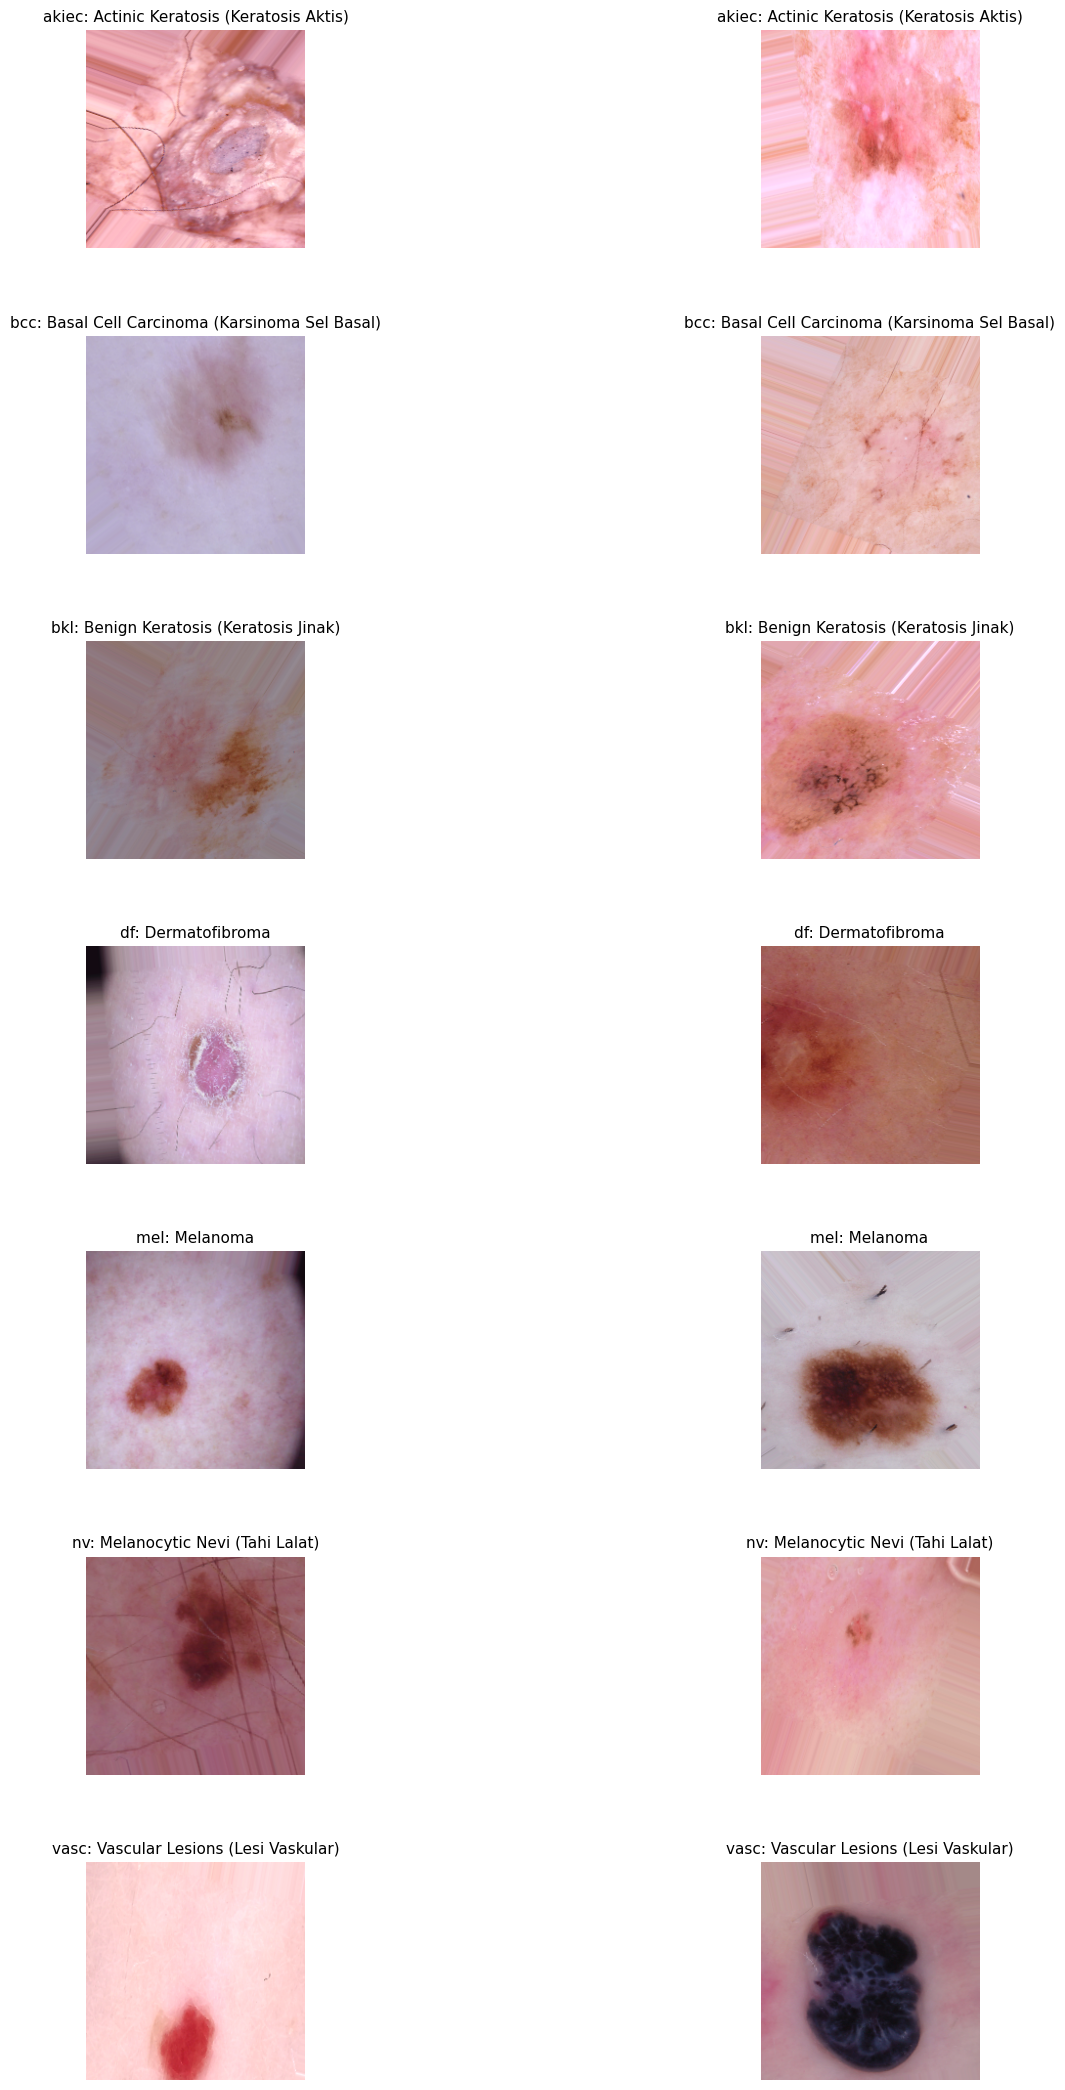

In [ ]:
# ======================================================
# Bagian 5: Data Augmentation dan Generators
# ======================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Baca dataframes yang sudah disimpan
train_df = pd.read_csv('/content/train_df.csv')
val_df = pd.read_csv('/content/val_df.csv')

# Pastikan semua path gambar adalah string
print(f"All image paths are strings: {all(train_df['image_path'].apply(lambda x: isinstance(x, str)))}")

# Verifikasi bahwa semua file gambar ada
missing_files_train = train_df[~train_df['image_path'].apply(os.path.exists)]
missing_files_val = val_df[~val_df['image_path'].apply(os.path.exists)]

if len(missing_files_train) > 0:
    print(f"WARNING: {len(missing_files_train)} missing image files in training set")
    train_df = train_df[train_df['image_path'].apply(os.path.exists)]

if len(missing_files_val) > 0:
    print(f"WARNING: {len(missing_files_val)} missing image files in validation set")
    val_df = val_df[val_df['image_path'].apply(os.path.exists)]

# Data Generators
print("\nMengkonfigurasi data generators dengan augmentasi...")

# Augmentasi untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.15
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk train dan validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Tampilkan pemetaan kelas ke indeks
class_indices = train_generator.class_indices
class_indices_reversed = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

# Cetak ukuran input dari generator untuk verifikasi
print(f"Ukuran input dari train_generator: {train_generator.image_shape}")
print(f"Jumlah kelas dari generator: {len(class_indices)}")

# Siapkan custom_objects untuk load model
custom_objects = {
    'CBAM': CBAM,
    'ChannelAttention': ChannelAttention,
    'SpatialAttention': SpatialAttention,
    'CastLayer': CastLayer
}

# Visualisasi beberapa contoh gambar dari setiap kelas setelah augmentasi
def plot_augmented_images(generator, class_indices_reversed, class_descriptions, num_images=2):
    """Menampilkan contoh gambar yang telah diaugmentasi untuk setiap kelas"""
    plt.figure(figsize=(18, len(class_indices_reversed) * 3))

    for i, class_idx in enumerate(range(len(class_indices_reversed))):
        class_name = class_indices_reversed[class_idx]
        # Ambil gambar dari kelas ini
        images_of_class = []
        labels_of_class = []

        # Batasi iterasi untuk menghindari loop tak terbatas
        max_iterations = 100
        for _ in range(max_iterations):
            try:
                x_batch, y_batch = next(generator)
                for img, label in zip(x_batch, y_batch):
                    if np.argmax(label) == class_idx and len(images_of_class) < num_images:
                        images_of_class.append(img)
                        labels_of_class.append(label)
                if len(images_of_class) >= num_images:
                    break
            except StopIteration:
                generator.reset()
                if len(images_of_class) == 0:
                    break

        # Plot gambar
        for j, img in enumerate(images_of_class):
            if j < num_images:  # Pastikan hanya menampilkan jumlah gambar yang diminta
                plt.subplot(len(class_indices_reversed), num_images, i * num_images + j + 1)
                plt.imshow(img)
                plt.title(f'{class_name}: {class_descriptions[class_name]}', fontsize=11)
                plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

# Buat generator khusus untuk visualisasi
viz_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=100  # Seed berbeda untuk variasi
)

print("Menampilkan contoh gambar yang diaugmentasi:")
plot_augmented_images(viz_generator, class_indices_reversed, class_descriptions, num_images=2)

Menggunakan ukuran input: (224, 224, 3)

Membuat model VGG16 dengan CBAM dan Progressive Learning...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam (CBAM)               │ (None, 7, 7, 512)      │         66,211 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_2    │ (None, 512)            │              0 │ cbam[0][0]             │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ cbam[0][0]             │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1024)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ concatenate_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 7)              │          1,799 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,445,994 (58.92 MB)

 Trainable params: 13,706,922 (52.29 MB)

 Non-trainable params: 1,739,072 (6.63 MB)


Training model VGG16...
Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.1740 - loss: 3.5704
Epoch 1: val_accuracy improved from -inf to 0.13975, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 93s 783ms/step - accuracy: 0.1740 - loss: 3.5691 - val_accuracy: 0.1398 - val_loss: 6.8006 - learning_rate: 1.0000e-04
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.1929 - loss: 3.3906
Epoch 2: val_accuracy did not improve from 0.13975
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.1929 - loss: 3.3909 - val_accuracy: 0.1398 - val_loss: 5.0142 - learning_rate: 1.0000e-04
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.1990 - loss: 3.3546
Epoch 3: val_accuracy improved from 0.13975 to 0.14286, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 360ms/step - accuracy: 0.1990 - loss: 3.3543 - val_accuracy: 0.1429 - val_loss: 11.4271 - learning_rate: 1.0000e-04
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.1856 - loss: 3.2975
Epoch 4: val_accuracy improved from 0.14286 to 0.18944, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 360ms/step - accuracy: 0.1857 - loss: 3.2965 - val_accuracy: 0.1894 - val_loss: 8.1622 - learning_rate: 1.0000e-04
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.1769 - loss: 3.1719
Epoch 5: val_accuracy did not improve from 0.18944
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.1769 - loss: 3.1716 - val_accuracy: 0.1677 - val_loss: 4.9167 - learning_rate: 1.0000e-04
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.1998 - loss: 3.1012
Epoch 6: val_accuracy did not improve from 0.18944
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.1999 - loss: 3.1007 - val_accuracy: 0.1584 - val_loss: 6.5383 - learning_rate: 1.0000e-04
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.2172 - loss: 3.0140
Epoch 7: val_accuracy did not improve from 0.18944
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.2174 - loss: 3.0138 - val_accuracy: 0.1584 - val_loss: 12.3166 - learning_rate: 1.0000e-04
E

81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 357ms/step - accuracy: 0.2885 - loss: 2.6548 - val_accuracy: 0.2050 - val_loss: 11.6554 - learning_rate: 1.0000e-04
Epoch 13/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.3200 - loss: 2.5121
Epoch 13: val_accuracy did not improve from 0.20497
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - accuracy: 0.3199 - loss: 2.5131 - val_accuracy: 0.1429 - val_loss: 13.4785 - learning_rate: 1.0000e-04
Epoch 14/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.2261 - loss: 2.8375
Epoch 14: val_accuracy did not improve from 0.20497
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 412ms/step - accuracy: 0.2262 - loss: 2.8373 - val_accuracy: 0.1398 - val_loss: 14.3572 - learning_rate: 1.0000e-04
Epoch 15/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2478 - loss: 2.8919
Epoch 15: val_accuracy did not improve from 0.20497

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 384ms/step - accuracy: 0.2477 

81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 349ms/step - accuracy: 0.2759 - loss: 2.6075 - val_accuracy: 0.2764 - val_loss: 3.2416 - learning_rate: 1.0000e-05
Epoch 21/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.2580 - loss: 2.6505
Epoch 21: val_accuracy improved from 0.27640 to 0.28571, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 388ms/step - accuracy: 0.2584 - loss: 2.6499 - val_accuracy: 0.2857 - val_loss: 2.8171 - learning_rate: 1.0000e-05
Epoch 22/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.3047 - loss: 2.6021
Epoch 22: val_accuracy improved from 0.28571 to 0.30124, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.3047 - loss: 2.6019 - val_accuracy: 0.3012 - val_loss: 2.3302 - learning_rate: 1.0000e-05
Epoch 23/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.3228 - loss: 2.5550
Epoch 23: val_accuracy improved from 0.30124 to 0.31366, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 353ms/step - accuracy: 0.3225 - loss: 2.5552 - val_accuracy: 0.3137 - val_loss: 2.5457 - learning_rate: 1.0000e-05
Epoch 24/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.2783 - loss: 2.5900
Epoch 24: val_accuracy improved from 0.31366 to 0.32298, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.2783 - loss: 2.5899 - val_accuracy: 0.3230 - val_loss: 2.5278 - learning_rate: 1.0000e-05
Epoch 25/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.2931 - loss: 2.5807
Epoch 25: val_accuracy improved from 0.32298 to 0.37888, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 354ms/step - accuracy: 0.2933 - loss: 2.5803 - val_accuracy: 0.3789 - val_loss: 2.2188 - learning_rate: 1.0000e-05
Epoch 26/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2744 - loss: 2.5687
Epoch 26: val_accuracy did not improve from 0.37888
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 391ms/step - accuracy: 0.2747 - loss: 2.5685 - val_accuracy: 0.2329 - val_loss: 2.6195 - learning_rate: 1.0000e-05
Epoch 27/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3130 - loss: 2.4419
Epoch 27: val_accuracy did not improve from 0.37888
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 344ms/step - accuracy: 0.3129 - loss: 2.4425 - val_accuracy: 0.3665 - val_loss: 2.1523 - learning_rate: 1.0000e-05
Epoch 28/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.3074 - loss: 2.4503
Epoch 28: val_accuracy did not improve from 0.37888
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 342ms/step - accuracy: 0.3073 - loss: 2.4508 - val_accuracy: 0.3168 - val_loss: 2.2420 - learning_rate: 1.0000e

81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - accuracy: 0.3191 - loss: 2.5808 - val_accuracy: 0.3975 - val_loss: 2.0559 - learning_rate: 1.0000e-05
Epoch 31/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3402 - loss: 2.4659
Epoch 31: val_accuracy did not improve from 0.39752
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.3401 - loss: 2.4658 - val_accuracy: 0.3509 - val_loss: 2.1913 - learning_rate: 1.0000e-05
Epoch 32/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.3277 - loss: 2.3849
Epoch 32: val_accuracy did not improve from 0.39752
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 349ms/step - accuracy: 0.3276 - loss: 2.3858 - val_accuracy: 0.3851 - val_loss: 2.0238 - learning_rate: 1.0000e-05
Epoch 33/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.3219 - loss: 2.4094
Epoch 33: val_accuracy did not improve from 0.39752
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 348ms/step - accuracy: 0.3217 - loss: 2.4102 - val_accuracy: 0.2547 - val_loss: 4.6472 - learning_rate: 1.0000e

81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 352ms/step - accuracy: 0.3193 - loss: 2.4811 - val_accuracy: 0.4006 - val_loss: 2.0545 - learning_rate: 1.0000e-05
Epoch 36/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3202 - loss: 2.4787
Epoch 36: val_accuracy did not improve from 0.40062
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.3202 - loss: 2.4784 - val_accuracy: 0.3199 - val_loss: 2.8824 - learning_rate: 1.0000e-05
Epoch 37/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3093 - loss: 2.5756
Epoch 37: val_accuracy improved from 0.40062 to 0.41925, saving model to best_VGG16.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.3094 - loss: 2.5747 - val_accuracy: 0.4193 - val_loss: 2.2637 - learning_rate: 1.0000e-05
Epoch 38/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.3072 - loss: 2.5484
Epoch 38: val_accuracy did not improve from 0.41925
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.3074 - loss: 2.5478 - val_accuracy: 0.3758 - val_loss: 2.1659 - learning_rate: 1.0000e-05
Epoch 39/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3504 - loss: 2.4023
Epoch 39: val_accuracy did not improve from 0.41925
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - accuracy: 0.3502 - loss: 2.4025 - val_accuracy: 0.4099 - val_loss: 2.2640 - learning_rate: 1.0000e-05
Epoch 40/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.3296 - loss: 2.4583
Epoch 40: val_accuracy did not improve from 0.41925
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.3296 - loss: 2.4580 - val_accuracy: 0.4193 - val_loss: 2.1412 - learning_rate: 1.0000e

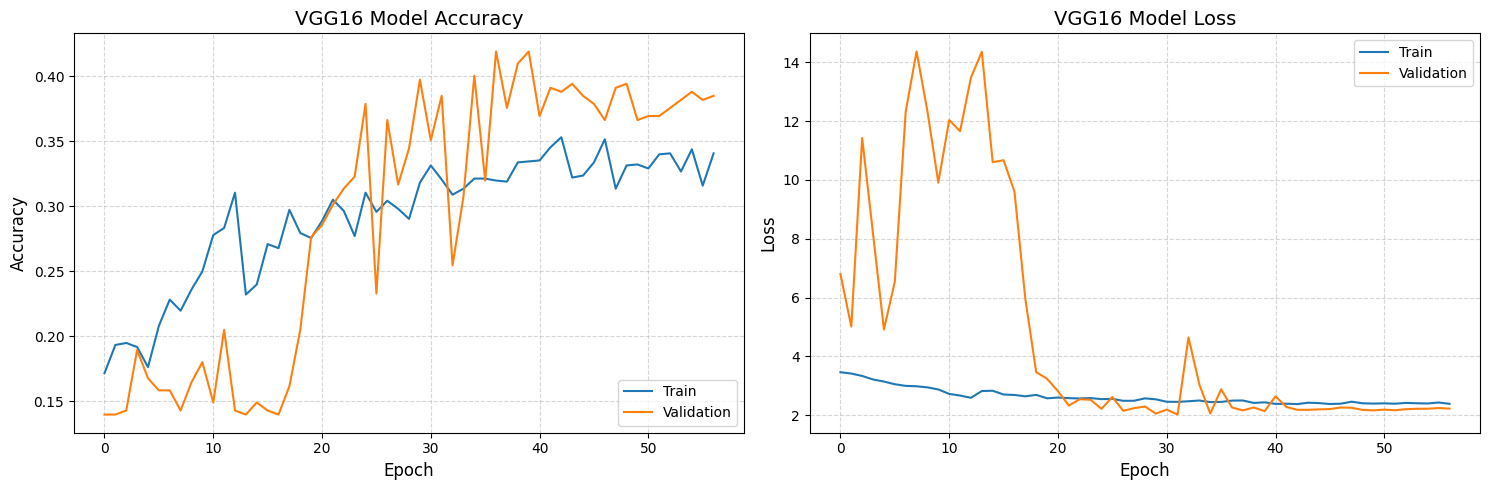


Evaluasi Model VGG16:
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


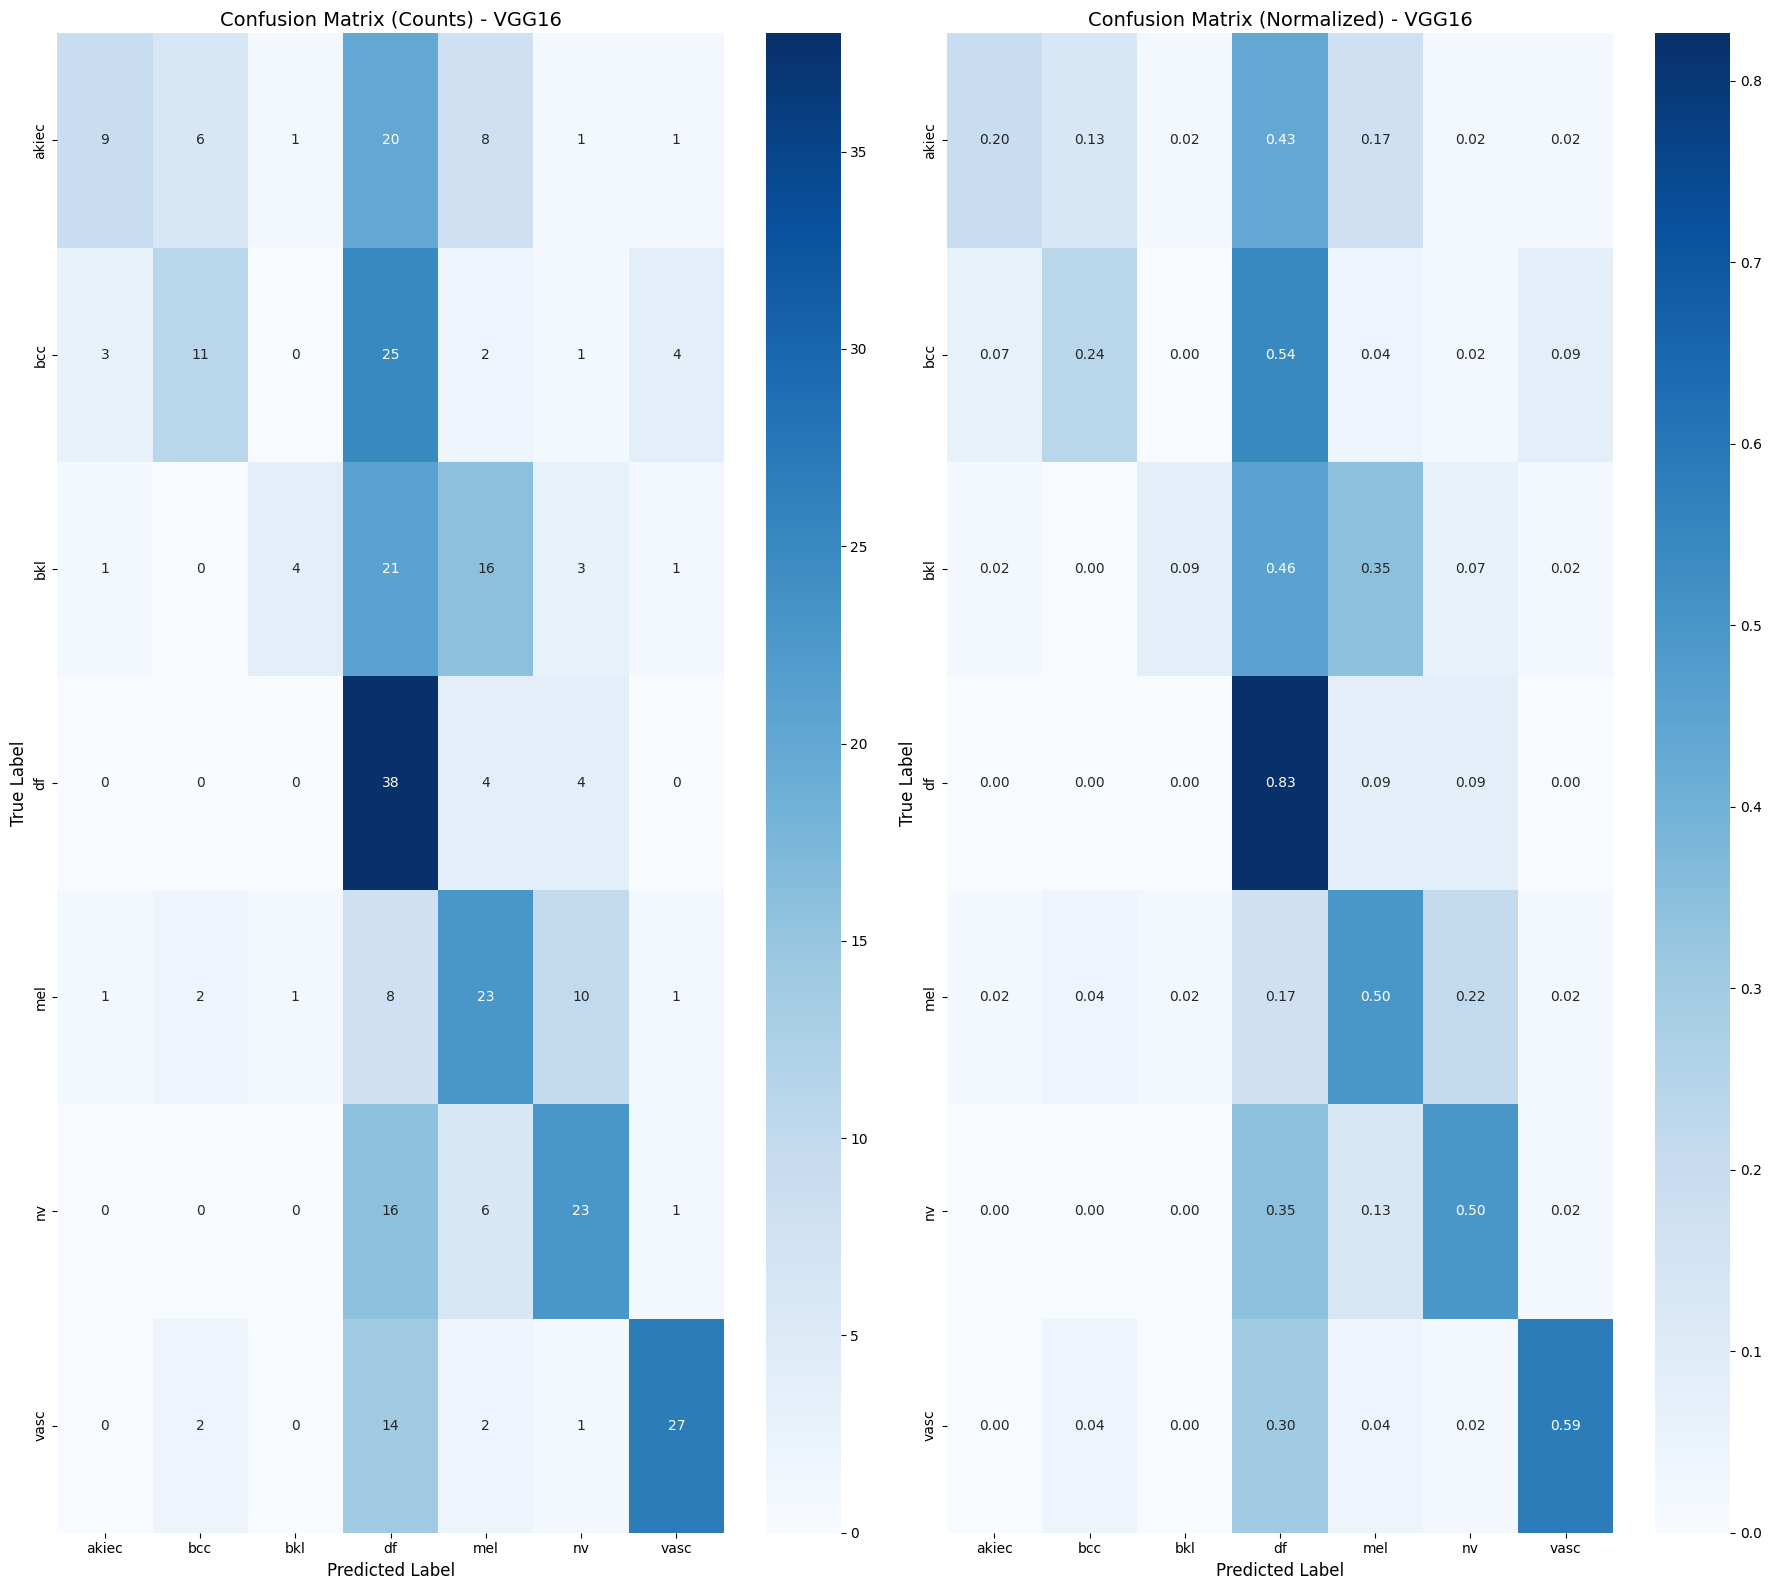


Classification Report - VGG16:
Accuracy: 0.4193

Per-Class Metrics:
Class akiec (Actinic Keratosis (Keratosis Aktis)):
  Precision: 0.6429
  Recall: 0.1957
  F1-score: 0.3000
  Support: 46.0
Class bcc (Basal Cell Carcinoma (Karsinoma Sel Basal)):
  Precision: 0.5238
  Recall: 0.2391
  F1-score: 0.3284
  Support: 46.0
Class bkl (Benign Keratosis (Keratosis Jinak)):
  Precision: 0.6667
  Recall: 0.0870
  F1-score: 0.1538
  Support: 46.0
Class df (Dermatofibroma):
  Precision: 0.2676
  Recall: 0.8261
  F1-score: 0.4043
  Support: 46.0
Class mel (Melanoma):
  Precision: 0.3770
  Recall: 0.5000
  F1-score: 0.4299
  Support: 46.0
Class nv (Melanocytic Nevi (Tahi Lalat)):
  Precision: 0.5349
  Recall: 0.5000
  F1-score: 0.5169
  Support: 46.0
Class vasc (Vascular Lesions (Lesi Vaskular)):
  Precision: 0.7714
  Recall: 0.5870
  F1-score: 0.6667
  Support: 46.0

Average Metrics:
  Macro Avg Precision: 0.5406
  Macro Avg Recall: 0.4193
  Macro Avg F1-score: 0.4000
  Weighted Avg Precision: 0.54

<Figure size 1600x1000 with 0 Axes>

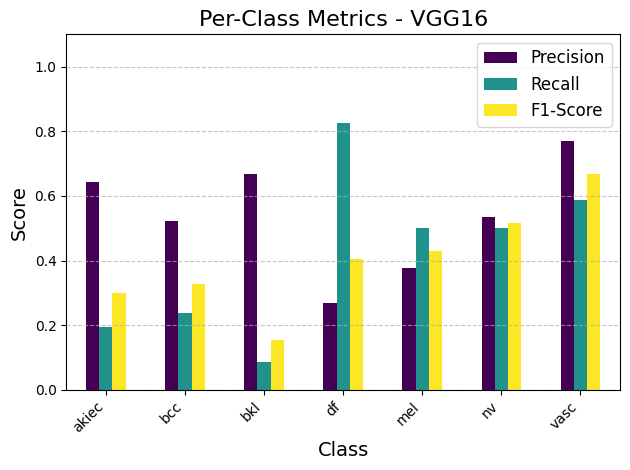

In [ ]:
# ======================================================
# Bagian 6: Model VGG16 dengan CBAM
# ======================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Sesuaikan ukuran input model dengan ukuran dari generator
img_shape = (IMG_SIZE, IMG_SIZE, 3)
print(f"Menggunakan ukuran input: {img_shape}")

# MODEL 1: VGG16 dengan CBAM dan Progressive Learning
print("\nMembuat model VGG16 dengan CBAM dan Progressive Learning...")
try:
    # Inisialisasi base model VGG16
    vgg16_base = VGG16(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Progressive unfreezing - hanya tiga blok terakhir yang dilatih
    for layer in vgg16_base.layers[:-8]:  # Bekukan semua layer kecuali 8 terakhir
        layer.trainable = False

    # Menerapkan CBAM pada VGG16
    vgg16_input = Input(shape=img_shape)
    x = vgg16_base(vgg16_input)

    # Tambahkan CBAM di akhir base model
    cbam = CBAM(ratio=8, kernel_size=7)
    x = cbam(x)

    # Global pooling dengan kombinasi max dan avg untuk informasi yang lebih kaya
    max_pool = GlobalMaxPooling2D()(x)
    avg_pool = GlobalAveragePooling2D()(x)
    x = Concatenate()([max_pool, avg_pool])

    # Classifier dengan dropout dan batch normalization
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    # Output layer untuk 7 kelas
    vgg16_output = Dense(len(class_indices), activation='softmax')(x)

    vgg16_model = Model(inputs=vgg16_input, outputs=vgg16_output, name='VGG16_Model')

    vgg16_model.summary()

    # Kompilasi model VGG16 dengan optimizer yang lebih baik
    vgg16_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model VGG16
    print("\nTraining model VGG16...")
    vgg16_history, vgg16_time = train_with_time(
        vgg16_model,
        train_generator,
        val_generator,
        EPOCHS,
        get_callbacks('VGG16'),
        "VGG16"
    )

    # Coba load model dengan strategi yang berbeda
    try:
        # Coba dengan custom_objects yang lengkap
        best_vgg16 = load_model('best_VGG16.h5', custom_objects=custom_objects)
    except:
        try:
            # Jika gagal, coba dengan scope
            with tf.keras.utils.custom_object_scope(custom_objects):
                best_vgg16 = load_model('best_VGG16.h5')
        except:
            # Jika masih gagal, gunakan model dari hasil training
            print("Tidak dapat memuat model tersimpan. Menggunakan model dari hasil training.")
            best_vgg16 = vgg16_model

    # Visualisasi hasil training VGG16
    if vgg16_history is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(vgg16_history.history['accuracy'])
        plt.plot(vgg16_history.history['val_accuracy'])
        plt.title('VGG16 Model Accuracy', size=14)
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(vgg16_history.history['loss'])
        plt.plot(vgg16_history.history['val_loss'])
        plt.title('VGG16 Model Loss', size=14)
        plt.ylabel('Loss', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Evaluasi VGG16
    vgg16_report, vgg16_cm, vgg16_metrics_df = evaluate_model(best_vgg16, val_generator, "VGG16")

    # Simpan hasil untuk perbandingan
    import pickle
    with open('vgg16_results.pkl', 'wb') as f:
        pickle.dump({
            'history': vgg16_history.history if vgg16_history else None,
            'time': vgg16_time,
            'report': vgg16_report,
            'metrics_df': vgg16_metrics_df
        }, f)

except Exception as e:
    import traceback
    print(f"Error saat membuat model VGG16: {e}")
    traceback.print_exc()


Membuat model MobileNetV2 dengan CBAM...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobileNetV2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam_1 (CBAM)             │ (None, 7, 7, 1280)     │        411,139 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_10   │ (None, 1280)           │              0 │ cbam_1[0][0]           │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ cbam_1[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 2560)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2560)           │         10,240 │ concatenate_10[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │      1,311,232 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 512)            │          2,048 │ dense_7[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        131,328 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256)            │          1,024 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 7)              │          1,799 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,126,794 (15.74 MB)

 Trainable params: 3,068,234 (11.70 MB)

 Non-trainable params: 1,058,560 (4.04 MB)


Training model MobileNetV2...
Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.1682 - loss: 3.6953
Epoch 1: val_accuracy improved from -inf to 0.23602, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 75s 603ms/step - accuracy: 0.1688 - loss: 3.6933 - val_accuracy: 0.2360 - val_loss: 2.8180 - learning_rate: 1.0000e-04
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.2674 - loss: 3.2640
Epoch 2: val_accuracy improved from 0.23602 to 0.31677, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.2676 - loss: 3.2637 - val_accuracy: 0.3168 - val_loss: 2.7198 - learning_rate: 1.0000e-04
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3083 - loss: 3.1412
Epoch 3: val_accuracy improved from 0.31677 to 0.36957, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.3084 - loss: 3.1408 - val_accuracy: 0.3696 - val_loss: 2.7996 - learning_rate: 1.0000e-04
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3748 - loss: 2.9555
Epoch 4: val_accuracy improved from 0.36957 to 0.39130, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 324ms/step - accuracy: 0.3747 - loss: 2.9556 - val_accuracy: 0.3913 - val_loss: 2.6564 - learning_rate: 1.0000e-04
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4018 - loss: 2.8411
Epoch 5: val_accuracy improved from 0.39130 to 0.40994, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.4017 - loss: 2.8415 - val_accuracy: 0.4099 - val_loss: 2.5869 - learning_rate: 1.0000e-04
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3646 - loss: 2.9280
Epoch 6: val_accuracy did not improve from 0.40994
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 332ms/step - accuracy: 0.3649 - loss: 2.9269 - val_accuracy: 0.3820 - val_loss: 2.6922 - learning_rate: 1.0000e-04
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3905 - loss: 2.8622
Epoch 7: val_accuracy improved from 0.40994 to 0.41615, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.3904 - loss: 2.8618 - val_accuracy: 0.4161 - val_loss: 2.8395 - learning_rate: 1.0000e-04
Epoch 8/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.4163 - loss: 2.7385
Epoch 8: val_accuracy improved from 0.41615 to 0.44099, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.4161 - loss: 2.7385 - val_accuracy: 0.4410 - val_loss: 2.7565 - learning_rate: 1.0000e-04
Epoch 9/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4160 - loss: 2.6853
Epoch 9: val_accuracy improved from 0.44099 to 0.45342, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 330ms/step - accuracy: 0.4162 - loss: 2.6845 - val_accuracy: 0.4534 - val_loss: 2.7649 - learning_rate: 1.0000e-04
Epoch 10/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4234 - loss: 2.6438
Epoch 10: val_accuracy did not improve from 0.45342
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - accuracy: 0.4236 - loss: 2.6433 - val_accuracy: 0.4410 - val_loss: 2.8468 - learning_rate: 1.0000e-04
Epoch 11/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4564 - loss: 2.5035
Epoch 11: val_accuracy improved from 0.45342 to 0.45652, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 333ms/step - accuracy: 0.4563 - loss: 2.5036 - val_accuracy: 0.4565 - val_loss: 2.6667 - learning_rate: 1.0000e-04
Epoch 12/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4812 - loss: 2.4829
Epoch 12: val_accuracy did not improve from 0.45652
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 329ms/step - accuracy: 0.4811 - loss: 2.4831 - val_accuracy: 0.4472 - val_loss: 2.6958 - learning_rate: 1.0000e-04
Epoch 13/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.4456 - loss: 2.5090
Epoch 13: val_accuracy improved from 0.45652 to 0.48758, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.4460 - loss: 2.5085 - val_accuracy: 0.4876 - val_loss: 2.5050 - learning_rate: 1.0000e-04
Epoch 14/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4752 - loss: 2.4521
Epoch 14: val_accuracy improved from 0.48758 to 0.49068, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 332ms/step - accuracy: 0.4754 - loss: 2.4516 - val_accuracy: 0.4907 - val_loss: 2.5330 - learning_rate: 1.0000e-04
Epoch 15/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4939 - loss: 2.3868
Epoch 15: val_accuracy improved from 0.49068 to 0.49379, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 342ms/step - accuracy: 0.4938 - loss: 2.3868 - val_accuracy: 0.4938 - val_loss: 2.7132 - learning_rate: 1.0000e-04
Epoch 16/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5050 - loss: 2.3536
Epoch 16: val_accuracy improved from 0.49379 to 0.50000, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.5049 - loss: 2.3537 - val_accuracy: 0.5000 - val_loss: 2.5333 - learning_rate: 1.0000e-04
Epoch 17/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4742 - loss: 2.4180
Epoch 17: val_accuracy did not improve from 0.50000
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 0.4744 - loss: 2.4175 - val_accuracy: 0.4938 - val_loss: 2.5916 - learning_rate: 1.0000e-04
Epoch 18/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5320 - loss: 2.3035
Epoch 18: val_accuracy improved from 0.50000 to 0.51553, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 328ms/step - accuracy: 0.5318 - loss: 2.3038 - val_accuracy: 0.5155 - val_loss: 2.4776 - learning_rate: 1.0000e-04
Epoch 19/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5267 - loss: 2.2324
Epoch 19: val_accuracy did not improve from 0.51553
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 318ms/step - accuracy: 0.5267 - loss: 2.2328 - val_accuracy: 0.4876 - val_loss: 2.4882 - learning_rate: 1.0000e-04
Epoch 20/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5499 - loss: 2.2083
Epoch 20: val_accuracy did not improve from 0.51553
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 358ms/step - accuracy: 0.5496 - loss: 2.2087 - val_accuracy: 0.4938 - val_loss: 2.5014 - learning_rate: 1.0000e-04
Epoch 21/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5289 - loss: 2.2300
Epoch 21: val_accuracy did not improve from 0.51553
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 321ms/step - accuracy: 0.5288 - loss: 2.2307 - val_accuracy: 0.4752 - val_loss: 2.6543 - learning_rate: 1.0000e

81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 328ms/step - accuracy: 0.5563 - loss: 2.1865 - val_accuracy: 0.5280 - val_loss: 2.4374 - learning_rate: 1.0000e-04
Epoch 23/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5734 - loss: 2.1149
Epoch 23: val_accuracy improved from 0.52795 to 0.54037, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 329ms/step - accuracy: 0.5733 - loss: 2.1154 - val_accuracy: 0.5404 - val_loss: 2.5272 - learning_rate: 1.0000e-04
Epoch 24/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5709 - loss: 2.0823
Epoch 24: val_accuracy did not improve from 0.54037
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - accuracy: 0.5709 - loss: 2.0826 - val_accuracy: 0.4969 - val_loss: 2.4351 - learning_rate: 1.0000e-04
Epoch 25/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5587 - loss: 2.1642
Epoch 25: val_accuracy did not improve from 0.54037
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 322ms/step - accuracy: 0.5587 - loss: 2.1638 - val_accuracy: 0.4969 - val_loss: 2.4041 - learning_rate: 1.0000e-04
Epoch 26/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6173 - loss: 2.0124
Epoch 26: val_accuracy did not improve from 0.54037
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 346ms/step - accuracy: 0.6170 - loss: 2.0128 - val_accuracy: 0.5280 - val_loss: 2.3178 - learning_rate: 1.0000e

81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.6299 - loss: 1.8928 - val_accuracy: 0.5559 - val_loss: 2.2697 - learning_rate: 1.0000e-04
Epoch 41/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6595 - loss: 1.7392
Epoch 41: val_accuracy did not improve from 0.55590
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - accuracy: 0.6594 - loss: 1.7398 - val_accuracy: 0.4938 - val_loss: 2.4577 - learning_rate: 1.0000e-04
Epoch 42/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6495 - loss: 1.8284
Epoch 42: val_accuracy did not improve from 0.55590
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 324ms/step - accuracy: 0.6496 - loss: 1.8286 - val_accuracy: 0.5155 - val_loss: 2.4747 - learning_rate: 1.0000e-04
Epoch 43/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6443 - loss: 1.8374
Epoch 43: val_accuracy did not improve from 0.55590
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 0.6443 - loss: 1.8377 - val_accuracy: 0.5466 - val_loss: 2.2260 - learning_rate: 1.0000e

81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.6504 - loss: 1.7730 - val_accuracy: 0.5621 - val_loss: 2.2229 - learning_rate: 1.0000e-04
Epoch 47/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6769 - loss: 1.7548
Epoch 47: val_accuracy improved from 0.56211 to 0.57453, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.6767 - loss: 1.7555 - val_accuracy: 0.5745 - val_loss: 2.2096 - learning_rate: 1.0000e-04
Epoch 48/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6976 - loss: 1.7146
Epoch 48: val_accuracy improved from 0.57453 to 0.60248, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.6975 - loss: 1.7150 - val_accuracy: 0.6025 - val_loss: 2.1596 - learning_rate: 1.0000e-04
Epoch 49/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6761 - loss: 1.7075
Epoch 49: val_accuracy did not improve from 0.60248
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 359ms/step - accuracy: 0.6759 - loss: 1.7082 - val_accuracy: 0.5932 - val_loss: 2.1163 - learning_rate: 1.0000e-04
Epoch 50/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6622 - loss: 1.7084
Epoch 50: val_accuracy improved from 0.60248 to 0.60870, saving model to best_MobileNetV2.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 328ms/step - accuracy: 0.6621 - loss: 1.7086 - val_accuracy: 0.6087 - val_loss: 2.0580 - learning_rate: 1.0000e-04
Epoch 51/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6408 - loss: 1.7806
Epoch 51: val_accuracy did not improve from 0.60870
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - accuracy: 0.6409 - loss: 1.7805 - val_accuracy: 0.5559 - val_loss: 2.1668 - learning_rate: 1.0000e-04
Epoch 52/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6843 - loss: 1.7159
Epoch 52: val_accuracy did not improve from 0.60870
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 320ms/step - accuracy: 0.6842 - loss: 1.7162 - val_accuracy: 0.5435 - val_loss: 2.2797 - learning_rate: 1.0000e-04
Epoch 53/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6732 - loss: 1.7373
Epoch 53: val_accuracy did not improve from 0.60870
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - accuracy: 0.6732 - loss: 1.7368 - val_accuracy: 0.5373 - val_loss: 2.4461 - learning_rate: 1.0000e

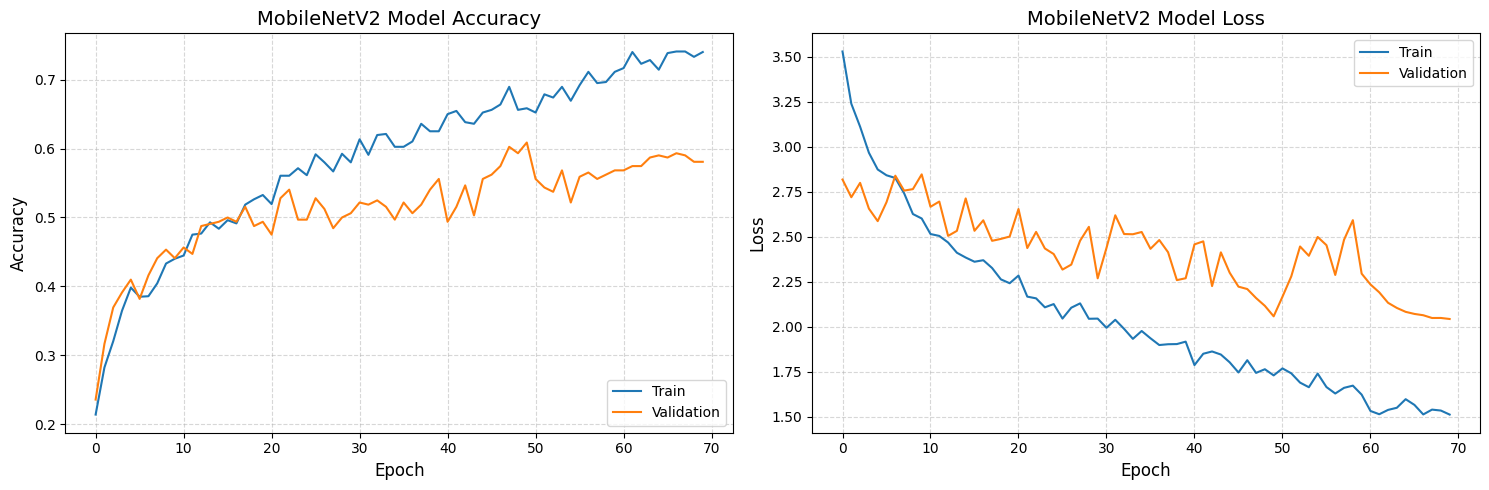


Evaluasi Model MobileNetV2:
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step


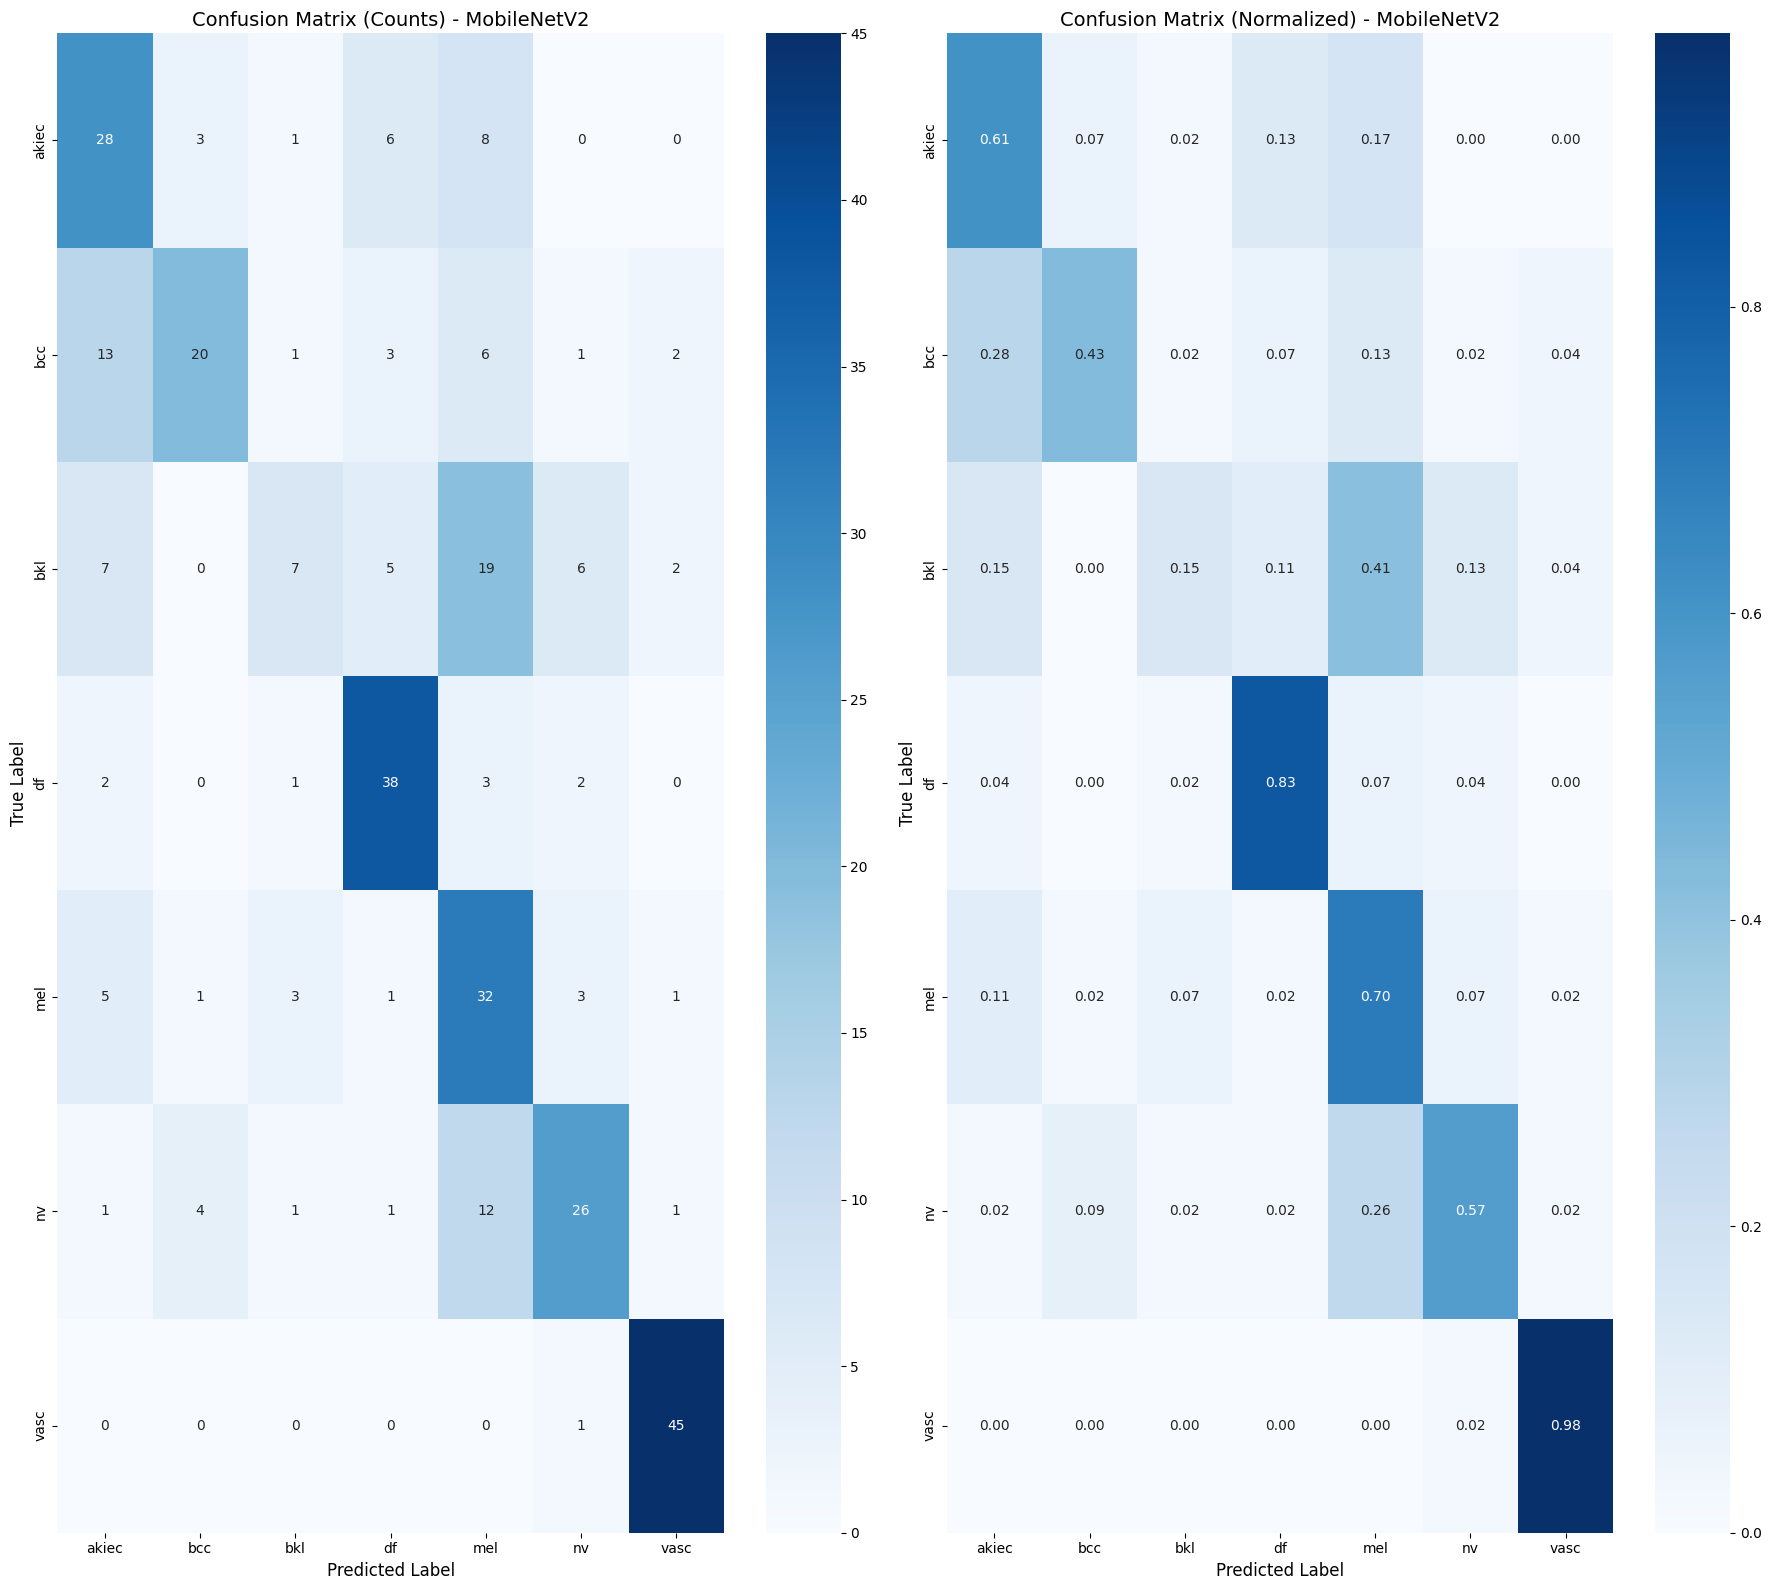


Classification Report - MobileNetV2:
Accuracy: 0.6087

Per-Class Metrics:
Class akiec (Actinic Keratosis (Keratosis Aktis)):
  Precision: 0.5000
  Recall: 0.6087
  F1-score: 0.5490
  Support: 46.0
Class bcc (Basal Cell Carcinoma (Karsinoma Sel Basal)):
  Precision: 0.7143
  Recall: 0.4348
  F1-score: 0.5405
  Support: 46.0
Class bkl (Benign Keratosis (Keratosis Jinak)):
  Precision: 0.5000
  Recall: 0.1522
  F1-score: 0.2333
  Support: 46.0
Class df (Dermatofibroma):
  Precision: 0.7037
  Recall: 0.8261
  F1-score: 0.7600
  Support: 46.0
Class mel (Melanoma):
  Precision: 0.4000
  Recall: 0.6957
  F1-score: 0.5079
  Support: 46.0
Class nv (Melanocytic Nevi (Tahi Lalat)):
  Precision: 0.6667
  Recall: 0.5652
  F1-score: 0.6118
  Support: 46.0
Class vasc (Vascular Lesions (Lesi Vaskular)):
  Precision: 0.8824
  Recall: 0.9783
  F1-score: 0.9278
  Support: 46.0

Average Metrics:
  Macro Avg Precision: 0.6239
  Macro Avg Recall: 0.6087
  Macro Avg F1-score: 0.5901
  Weighted Avg Precision

<Figure size 1600x1000 with 0 Axes>

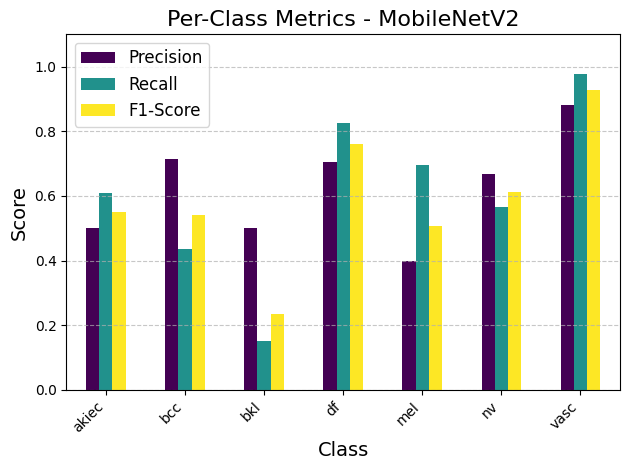

In [ ]:
# ======================================================
# Bagian 7: Model MobileNet dengan CBAM
# ======================================================

from tensorflow.keras.applications import MobileNetV2

# MODEL 2: MobileNetV2 dengan CBAM
print("\nMembuat model MobileNetV2 dengan CBAM...")
try:
    mobilenetv2_base = MobileNetV2(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Progressive unfreezing - untuk MobileNetV2
    for layer in mobilenetv2_base.layers[:-20]:  # Bekukan semua layer kecuali 20 terakhir
        layer.trainable = False

    # Menerapkan CBAM pada MobileNetV2
    mobilenetv2_input = Input(shape=img_shape)
    x = mobilenetv2_base(mobilenetv2_input)

    # Tambahkan CBAM
    cbam_mobilenet = CBAM(ratio=8, kernel_size=7)
    x = cbam_mobilenet(x)

    # Global pooling dengan kombinasi max dan avg
    max_pool = GlobalMaxPooling2D()(x)
    avg_pool = GlobalAveragePooling2D()(x)
    x = Concatenate()([max_pool, avg_pool])

    # Classifier dengan dropout dan batch normalization yang dioptimasi
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    # Output layer untuk 7 kelas
    mobilenetv2_output = Dense(len(class_indices), activation='softmax')(x)

    mobilenetv2_model = Model(inputs=mobilenetv2_input, outputs=mobilenetv2_output, name='MobileNetV2_Model')

    mobilenetv2_model.summary()

    # Kompilasi model MobileNetV2
    mobilenetv2_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model MobileNetV2
    print("\nTraining model MobileNetV2...")
    mobilenetv2_history, mobilenetv2_time = train_with_time(
        mobilenetv2_model,
        train_generator,
        val_generator,
        EPOCHS,
        get_callbacks('MobileNetV2'),
        "MobileNetV2"
    )

    # Load model terbaik
    try:
        best_mobilenetv2 = load_model('best_MobileNetV2.h5', custom_objects=custom_objects)
    except:
        try:
            # Jika gagal, coba dengan scope
            with tf.keras.utils.custom_object_scope(custom_objects):
                best_mobilenetv2 = load_model('best_MobileNetV2.h5')
        except:
            # Jika masih gagal, gunakan model dari hasil training
            print("Tidak dapat memuat model MobileNetV2 tersimpan. Menggunakan model dari hasil training.")
            best_mobilenetv2 = mobilenetv2_model

    # Visualisasi hasil training MobileNetV2
    if mobilenetv2_history is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(mobilenetv2_history.history['accuracy'])
        plt.plot(mobilenetv2_history.history['val_accuracy'])
        plt.title('MobileNetV2 Model Accuracy', size=14)
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(mobilenetv2_history.history['loss'])
        plt.plot(mobilenetv2_history.history['val_loss'])
        plt.title('MobileNetV2 Model Loss', size=14)
        plt.ylabel('Loss', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Evaluasi MobileNetV2
    mobilenetv2_report, mobilenetv2_cm, mobilenetv2_metrics_df = evaluate_model(best_mobilenetv2, val_generator, "MobileNetV2")

    # Simpan hasil untuk perbandingan
    import pickle
    with open('mobilenetv2_results.pkl', 'wb') as f:
        pickle.dump({
            'history': mobilenetv2_history.history if mobilenetv2_history else None,
            'time': mobilenetv2_time,
            'report': mobilenetv2_report,
            'metrics_df': mobilenetv2_metrics_df
        }, f)

except Exception as e:
    import traceback
    print(f"Error saat membuat model MobileNetV2: {e}")
    traceback.print_exc()


Membuat Optimized Combined Model dengan attention mechanism...


Model: "Combined_VGG16_MobileNetV2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ combined_input            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ combined_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ combined_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam_2 (CBAM)             │ (None, 7, 7, 512)      │         66,211 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam_3 (CBAM)             │ (None, 7, 7, 1280)     │        411,139 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_20   │ (None, 512)            │              0 │ cbam_2[0][0]           │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ cbam_2[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_21   │ (None, 1280)           │              0 │ cbam_3[0][0]           │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ cbam_3[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_20            │ (None, 1024)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21            │ (None, 2560)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 1024)           │          4,096 │ concatenate_20[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 2560)           │         10,240 │ concatenate_21[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │        131,200 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)     

 Total params: 19,942,191 (76.07 MB)

 Trainable params: 18,769,839 (71.60 MB)

 Non-trainable params: 1,172,352 (4.47 MB)


Training Combined Model...
Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.1462 - loss: 3.8438
Epoch 1: val_accuracy improved from -inf to 0.16770, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 141s 858ms/step - accuracy: 0.1464 - loss: 3.8431 - val_accuracy: 0.1677 - val_loss: 2.8283 - learning_rate: 5.0000e-05
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1993 - loss: 3.6274
Epoch 2: val_accuracy improved from 0.16770 to 0.20807, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 383ms/step - accuracy: 0.1994 - loss: 3.6260 - val_accuracy: 0.2081 - val_loss: 3.0705 - learning_rate: 5.0000e-05
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2027 - loss: 3.4057
Epoch 3: val_accuracy improved from 0.20807 to 0.21118, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 379ms/step - accuracy: 0.2028 - loss: 3.4055 - val_accuracy: 0.2112 - val_loss: 3.6003 - learning_rate: 5.0000e-05
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.2168 - loss: 3.3531
Epoch 4: val_accuracy improved from 0.21118 to 0.22671, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 373ms/step - accuracy: 0.2170 - loss: 3.3520 - val_accuracy: 0.2267 - val_loss: 3.4966 - learning_rate: 5.0000e-05
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.2277 - loss: 3.2214
Epoch 5: val_accuracy did not improve from 0.22671
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 352ms/step - accuracy: 0.2278 - loss: 3.2214 - val_accuracy: 0.2236 - val_loss: 3.6752 - learning_rate: 5.0000e-05
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2526 - loss: 3.0996
Epoch 6: val_accuracy did not improve from 0.22671
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 363ms/step - accuracy: 0.2527 - loss: 3.0998 - val_accuracy: 0.1801 - val_loss: 6.5905 - learning_rate: 5.0000e-05
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.2820 - loss: 3.0184
Epoch 7: val_accuracy improved from 0.22671 to 0.23292, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 421ms/step - accuracy: 0.2821 - loss: 3.0186 - val_accuracy: 0.2329 - val_loss: 4.7582 - learning_rate: 5.0000e-05
Epoch 8/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2795 - loss: 3.0098
Epoch 8: val_accuracy improved from 0.23292 to 0.28261, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.2796 - loss: 3.0099 - val_accuracy: 0.2826 - val_loss: 3.8939 - learning_rate: 5.0000e-05
Epoch 9/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3051 - loss: 3.0521
Epoch 9: val_accuracy improved from 0.28261 to 0.32919, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 388ms/step - accuracy: 0.3049 - loss: 3.0521 - val_accuracy: 0.3292 - val_loss: 3.5359 - learning_rate: 5.0000e-05
Epoch 10/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3103 - loss: 2.9444
Epoch 10: val_accuracy did not improve from 0.32919
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 354ms/step - accuracy: 0.3102 - loss: 2.9448 - val_accuracy: 0.2857 - val_loss: 3.4661 - learning_rate: 5.0000e-05
Epoch 11/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3030 - loss: 3.0294
Epoch 11: val_accuracy did not improve from 0.32919

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.3033 - loss: 3.0285 - val_accuracy: 0.2919 - val_loss: 3.5070 - learning_rate: 5.0000e-05
Epoch 12/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3152 - loss: 2.9645
Epoch 12: val_accuracy did not improve from 0.32919
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - accuracy: 0.3153 - l

81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 429ms/step - accuracy: 0.3324 - loss: 2.7959 - val_accuracy: 0.3509 - val_loss: 3.0516 - learning_rate: 5.0000e-06
Epoch 14/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.3047 - loss: 2.8521
Epoch 14: val_accuracy improved from 0.35093 to 0.36957, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.3049 - loss: 2.8521 - val_accuracy: 0.3696 - val_loss: 2.9916 - learning_rate: 5.0000e-06
Epoch 15/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.3200 - loss: 2.9081
Epoch 15: val_accuracy improved from 0.36957 to 0.37888, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3200 - loss: 2.9080 - val_accuracy: 0.3789 - val_loss: 2.9290 - learning_rate: 5.0000e-06
Epoch 16/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2991 - loss: 2.8635
Epoch 16: val_accuracy did not improve from 0.37888
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.2991 - loss: 2.8634 - val_accuracy: 0.3758 - val_loss: 2.8754 - learning_rate: 5.0000e-06
Epoch 17/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3072 - loss: 2.8305
Epoch 17: val_accuracy improved from 0.37888 to 0.38509, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step - accuracy: 0.3072 - loss: 2.8305 - val_accuracy: 0.3851 - val_loss: 2.8144 - learning_rate: 5.0000e-06
Epoch 18/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3499 - loss: 2.8023
Epoch 18: val_accuracy did not improve from 0.38509
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 358ms/step - accuracy: 0.3498 - loss: 2.8025 - val_accuracy: 0.3758 - val_loss: 2.7602 - learning_rate: 5.0000e-06
Epoch 19/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3433 - loss: 2.8253
Epoch 19: val_accuracy improved from 0.38509 to 0.39130, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - accuracy: 0.3432 - loss: 2.8253 - val_accuracy: 0.3913 - val_loss: 2.7667 - learning_rate: 5.0000e-06
Epoch 20/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3266 - loss: 2.8451
Epoch 20: val_accuracy improved from 0.39130 to 0.39441, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 389ms/step - accuracy: 0.3264 - loss: 2.8452 - val_accuracy: 0.3944 - val_loss: 2.7299 - learning_rate: 5.0000e-06
Epoch 21/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3275 - loss: 2.8177
Epoch 21: val_accuracy did not improve from 0.39441
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.3275 - loss: 2.8176 - val_accuracy: 0.3944 - val_loss: 2.6744 - learning_rate: 5.0000e-06
Epoch 22/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.3235 - loss: 2.8473
Epoch 22: val_accuracy did not improve from 0.39441
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 359ms/step - accuracy: 0.3235 - loss: 2.8474 - val_accuracy: 0.3913 - val_loss: 2.6881 - learning_rate: 5.0000e-06
Epoch 23/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3375 - loss: 2.7833
Epoch 23: val_accuracy improved from 0.39441 to 0.40062, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 453ms/step - accuracy: 0.3376 - loss: 2.7831 - val_accuracy: 0.4006 - val_loss: 2.6564 - learning_rate: 5.0000e-06
Epoch 24/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3242 - loss: 2.8718
Epoch 24: val_accuracy improved from 0.40062 to 0.40373, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 380ms/step - accuracy: 0.3242 - loss: 2.8712 - val_accuracy: 0.4037 - val_loss: 2.6402 - learning_rate: 5.0000e-06
Epoch 25/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3512 - loss: 2.7716
Epoch 25: val_accuracy improved from 0.40373 to 0.40683, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.3511 - loss: 2.7723 - val_accuracy: 0.4068 - val_loss: 2.6454 - learning_rate: 5.0000e-06
Epoch 26/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.3349 - loss: 2.7461
Epoch 26: val_accuracy did not improve from 0.40683
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 355ms/step - accuracy: 0.3349 - loss: 2.7470 - val_accuracy: 0.4068 - val_loss: 2.6612 - learning_rate: 5.0000e-06
Epoch 27/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.3308 - loss: 2.8350
Epoch 27: val_accuracy improved from 0.40683 to 0.42547, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - accuracy: 0.3309 - loss: 2.8348 - val_accuracy: 0.4255 - val_loss: 2.6199 - learning_rate: 5.0000e-06
Epoch 28/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.3848 - loss: 2.7231
Epoch 28: val_accuracy did not improve from 0.42547
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 380ms/step - accuracy: 0.3846 - loss: 2.7240 - val_accuracy: 0.4193 - val_loss: 2.5930 - learning_rate: 5.0000e-06
Epoch 29/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.3519 - loss: 2.8108
Epoch 29: val_accuracy improved from 0.42547 to 0.43478, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 429ms/step - accuracy: 0.3520 - loss: 2.8106 - val_accuracy: 0.4348 - val_loss: 2.5353 - learning_rate: 5.0000e-06
Epoch 30/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3354 - loss: 2.8136
Epoch 30: val_accuracy improved from 0.43478 to 0.44099, saving model to best_Combined.h5


81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.3355 - loss: 2.8137 - val_accuracy: 0.4410 - val_loss: 2.5710 - learning_rate: 5.0000e-06
Epoch 31/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3557 - loss: 2.7857
Epoch 31: val_accuracy did not improve from 0.44099
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 354ms/step - accuracy: 0.3557 - loss: 2.7855 - val_accuracy: 0.4410 - val_loss: 2.5688 - learning_rate: 5.0000e-06
Epoch 32/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3268 - loss: 2.8456
Epoch 32: val_accuracy did not improve from 0.44099
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 365ms/step - accuracy: 0.3269 - loss: 2.8449 - val_accuracy: 0.4193 - val_loss: 2.5551 - learning_rate: 5.0000e-06
Epoch 33/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3695 - loss: 2.6585
Epoch 33: val_accuracy did not improve from 0.44099
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 354ms/step - accuracy: 0.3693 - loss: 2.6592 - val_accuracy: 0.4379 - val_loss: 2.5224 - learning_rate: 5.0000e

81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 421ms/step - accuracy: 0.3355 - loss: 2.6911 - val_accuracy: 0.4503 - val_loss: 2.4802 - learning_rate: 5.0000e-06
Epoch 36/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3435 - loss: 2.7322
Epoch 36: val_accuracy did not improve from 0.45031
81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 363ms/step - accuracy: 0.3436 - loss: 2.7325 - val_accuracy: 0.4441 - val_loss: 2.5167 - learning_rate: 5.0000e-06
Epoch 37/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.3574 - loss: 2.7682
Epoch 37: val_accuracy did not improve from 0.45031
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 373ms/step - accuracy: 0.3574 - loss: 2.7680 - val_accuracy: 0.4410 - val_loss: 2.5161 - learning_rate: 5.0000e-06
Epoch 38/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.3620 - loss: 2.8105
Epoch 38: val_accuracy did not improve from 0.45031
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 352ms/step - accuracy: 0.3618 - loss: 2.8102 - val_accuracy: 0.4441 - val_loss: 2.5153 - learning_rate: 5.0000e

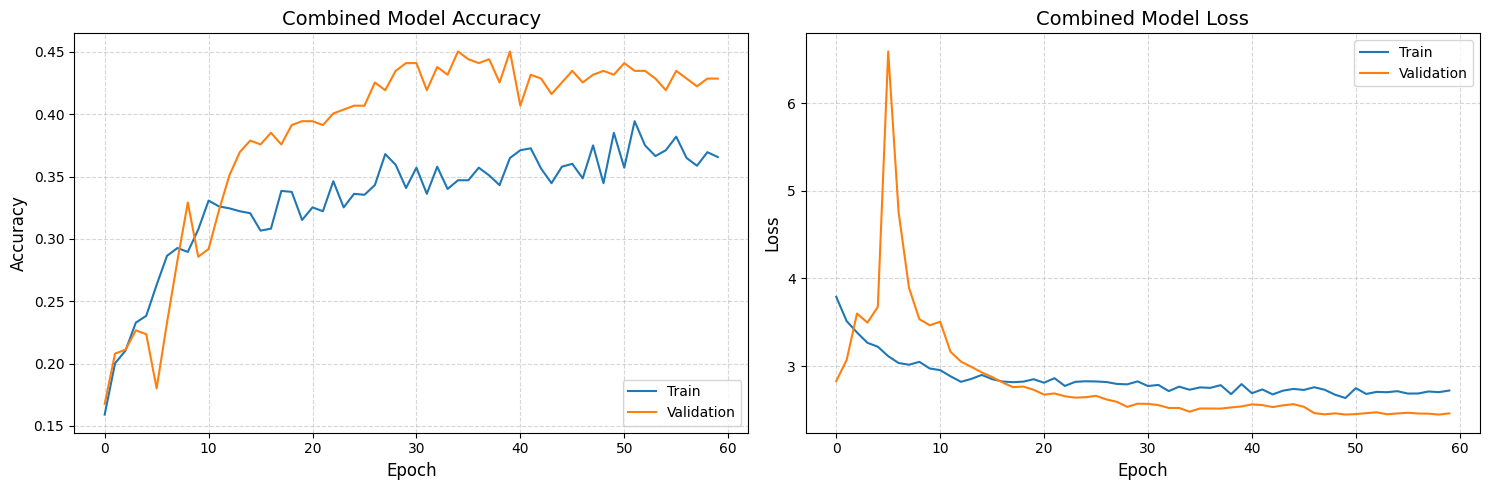


Evaluasi Model Combined VGG16-MobileNetV2:
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step


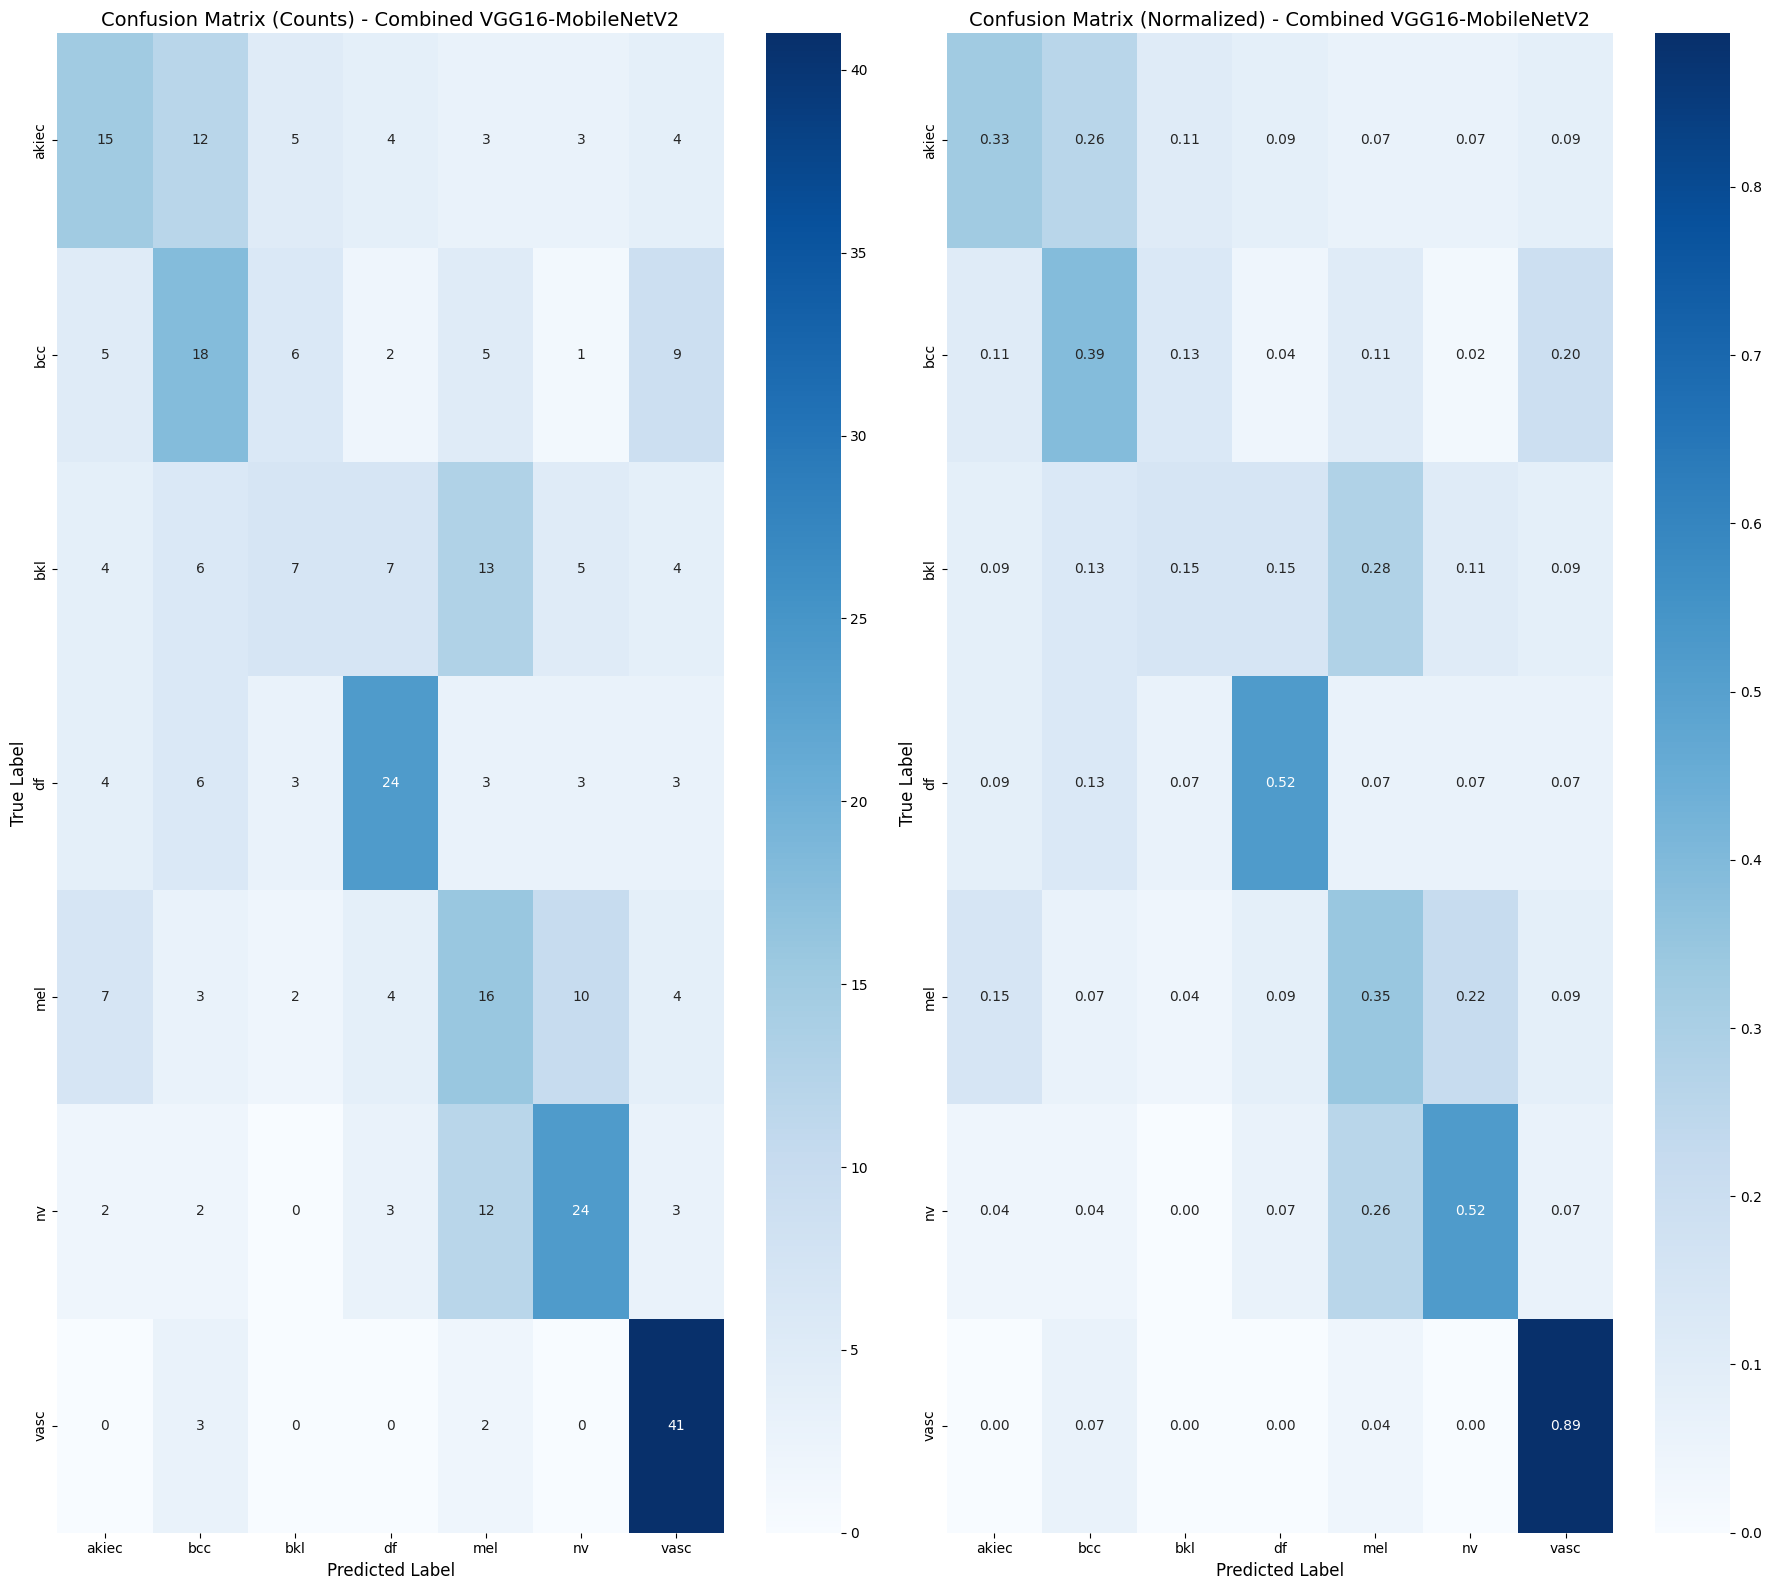


Classification Report - Combined VGG16-MobileNetV2:
Accuracy: 0.4503

Per-Class Metrics:
Class akiec (Actinic Keratosis (Keratosis Aktis)):
  Precision: 0.4054
  Recall: 0.3261
  F1-score: 0.3614
  Support: 46.0
Class bcc (Basal Cell Carcinoma (Karsinoma Sel Basal)):
  Precision: 0.3600
  Recall: 0.3913
  F1-score: 0.3750
  Support: 46.0
Class bkl (Benign Keratosis (Keratosis Jinak)):
  Precision: 0.3043
  Recall: 0.1522
  F1-score: 0.2029
  Support: 46.0
Class df (Dermatofibroma):
  Precision: 0.5455
  Recall: 0.5217
  F1-score: 0.5333
  Support: 46.0
Class mel (Melanoma):
  Precision: 0.2963
  Recall: 0.3478
  F1-score: 0.3200
  Support: 46.0
Class nv (Melanocytic Nevi (Tahi Lalat)):
  Precision: 0.5217
  Recall: 0.5217
  F1-score: 0.5217
  Support: 46.0
Class vasc (Vascular Lesions (Lesi Vaskular)):
  Precision: 0.6029
  Recall: 0.8913
  F1-score: 0.7193
  Support: 46.0

Average Metrics:
  Macro Avg Precision: 0.4337
  Macro Avg Recall: 0.4503
  Macro Avg F1-score: 0.4334
  Weighte

<Figure size 1600x1000 with 0 Axes>

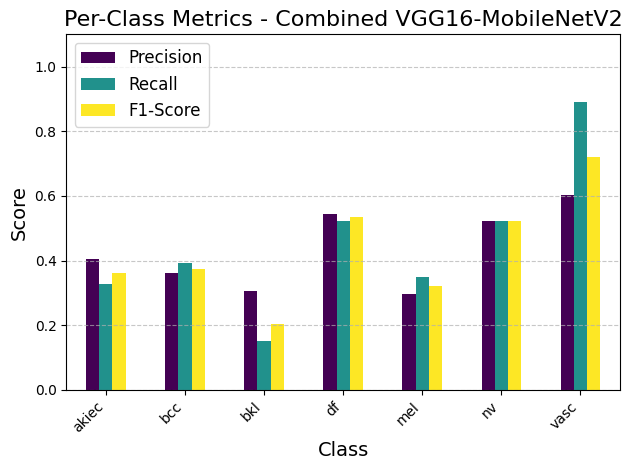

In [ ]:
# ======================================================
# Bagian 8: Model Gabungan VGG16 & MobileNet
# ======================================================

# MODEL 3: OPTIMIZED COMBINED MODEL (Kombinasi VGG16 dan MobileNetV2)
print("\nMembuat Optimized Combined Model dengan attention mechanism...")
try:
    # Buat base model baru untuk model kombinasi
    vgg16_base_combined = VGG16(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Fine-tuning untuk VGG16
    for layer in vgg16_base_combined.layers[:-12]:  # Fine-tune lebih banyak layer
        layer.trainable = False

    # Buat base model MobileNetV2 baru
    mobilenetv2_base_combined = MobileNetV2(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Fine-tuning untuk MobileNetV2
    for layer in mobilenetv2_base_combined.layers[:-25]:  # Fine-tune lebih banyak layer
        layer.trainable = False

    # Buat input baru
    combined_input = Input(shape=img_shape, name='combined_input')

    # Ekstrak fitur dari kedua model
    vgg16_features = vgg16_base_combined(combined_input)
    mobilenetv2_features = mobilenetv2_base_combined(combined_input)

    # Tambahkan CBAM ke kedua model
    cbam_vgg = CBAM(ratio=8, kernel_size=7)
    cbam_mobilenet = CBAM(ratio=8, kernel_size=7)
    vgg16_cbam = cbam_vgg(vgg16_features)
    mobilenetv2_cbam = cbam_mobilenet(mobilenetv2_features)

    # Global pooling yang dioptimasi (menggunakan kombinasi max dan avg)
    vgg16_max_pool = GlobalMaxPooling2D()(vgg16_cbam)
    vgg16_avg_pool = GlobalAveragePooling2D()(vgg16_cbam)
    vgg16_pooled = Concatenate()([vgg16_max_pool, vgg16_avg_pool])

    mobilenetv2_max_pool = GlobalMaxPooling2D()(mobilenetv2_cbam)
    mobilenetv2_avg_pool = GlobalAveragePooling2D()(mobilenetv2_cbam)
    mobilenetv2_pooled = Concatenate()([mobilenetv2_max_pool, mobilenetv2_avg_pool])

    # Batch normalization
    vgg16_bn = BatchNormalization()(vgg16_pooled)
    mobilenetv2_bn = BatchNormalization()(mobilenetv2_pooled)

    # Attention mechanism dengan self-attention
    vgg16_dense = Dense(128, activation='relu')(vgg16_bn)
    mobilenetv2_dense = Dense(128, activation='relu')(mobilenetv2_bn)

    # Self-attention weights
    vgg16_attention = Dense(1, activation='sigmoid', name='vgg16_attention')(vgg16_dense)
    mobilenetv2_attention = Dense(1, activation='sigmoid', name='mobilenetv2_attention')(mobilenetv2_dense)

    # Normalize attention weights
    attention_concat = Concatenate()([vgg16_attention, mobilenetv2_attention])
    attention_activation = Activation('softmax')(attention_concat)

    # Split normalized attention
    vgg16_attention_weight = Lambda(lambda x: x[:, 0:1])(attention_activation)
    mobilenetv2_attention_weight = Lambda(lambda x: x[:, 1:2])(attention_activation)

    # Apply attention weights
    vgg16_weighted = Multiply()([vgg16_bn, vgg16_attention_weight])
    mobilenetv2_weighted = Multiply()([mobilenetv2_bn, mobilenetv2_attention_weight])

    # Gabungkan fitur dengan attention weights
    combined_features = Concatenate(name='combined_features')([vgg16_weighted, mobilenetv2_weighted])

    # Classifier yang lebih dalam dan teroptimasi
    x = BatchNormalization()(combined_features)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0003))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0003))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0003))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    # Output layer untuk 7 kelas
    combined_output = Dense(len(class_indices), activation='softmax', name='combined_output')(x)

    # Buat model kombinasi
    combined_model = Model(inputs=combined_input, outputs=combined_output, name='Combined_VGG16_MobileNetV2_Model')

    # Kompilasi model kombinasi
    combined_model.compile(
        optimizer=Adam(learning_rate=0.00005),  # Learning rate yang lebih kecil
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    combined_model.summary()

    # Callbacks untuk model gabungan dengan patience yang lebih tinggi
    combined_callbacks = [
        ModelCheckpoint(
            filepath='best_Combined.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=25,  # Lebih sabar untuk model gabungan
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train model gabungan
    print("\nTraining Combined Model...")
    combined_history, combined_time = train_with_time(
        combined_model,
        train_generator,
        val_generator,
        EPOCHS,
        combined_callbacks,
        "Combined"
    )

    # Load model terbaik
    try:
        best_combined = load_model('best_Combined.h5', custom_objects=custom_objects)
    except:
        try:
            # Jika gagal, coba dengan scope
            with tf.keras.utils.custom_object_scope(custom_objects):
                best_combined = load_model('best_Combined.h5')
        except:
            # Jika masih gagal, gunakan model dari hasil training
            print("Tidak dapat memuat model Combined tersimpan. Menggunakan model dari hasil training.")
            best_combined = combined_model

    # Visualisasi hasil training model gabungan
    if combined_history is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(combined_history.history['accuracy'])
        plt.plot(combined_history.history['val_accuracy'])
        plt.title('Combined Model Accuracy', size=14)
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(combined_history.history['loss'])
        plt.plot(combined_history.history['val_loss'])
        plt.title('Combined Model Loss', size=14)
        plt.ylabel('Loss', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Evaluasi model gabungan
    combined_report, combined_cm, combined_metrics_df = evaluate_model(best_combined, val_generator, "Combined VGG16-MobileNetV2")

    # Simpan hasil untuk perbandingan
    import pickle
    with open('combined_results.pkl', 'wb') as f:
        pickle.dump({
            'history': combined_history.history if combined_history else None,
            'time': combined_time,
            'report': combined_report,
            'metrics_df': combined_metrics_df
        }, f)

except Exception as e:
    import traceback
    print(f"Error saat membuat Combined Model: {e}")
    traceback.print_exc()


----- PERBANDINGAN MODEL UNTUK 7 KATEGORI KANKER KULIT -----


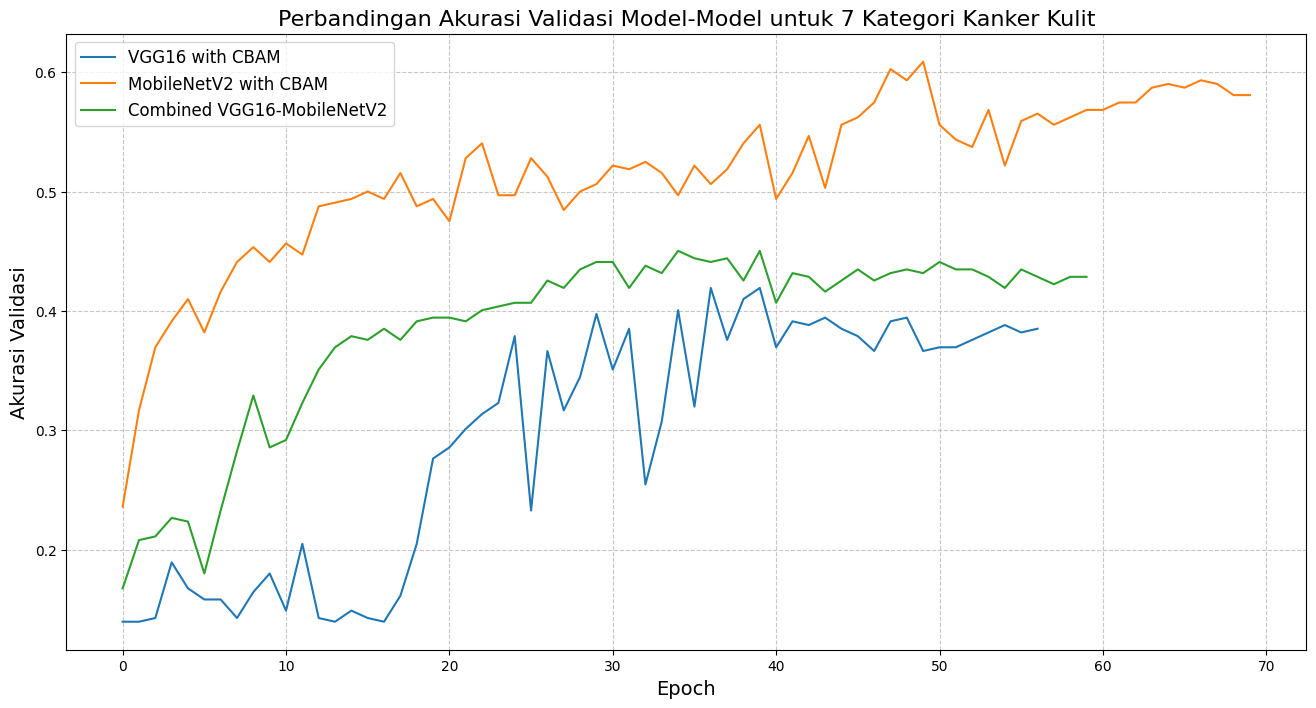


Perbandingan Akurasi Validasi Terbaik:
VGG16 with CBAM: 0.4193
MobileNetV2 with CBAM: 0.6087
Combined VGG16-MobileNetV2: 0.4503

Perbandingan Waktu Pelatihan (detik):
VGG16 with CBAM: 1802.75
MobileNetV2 with CBAM: 2005.69
Combined VGG16-MobileNetV2: 1975.70

Perbandingan Waktu Pelatihan per Epoch (detik):
VGG16 with CBAM: 31.63
MobileNetV2 with CBAM: 28.65
Combined VGG16-MobileNetV2: 32.93


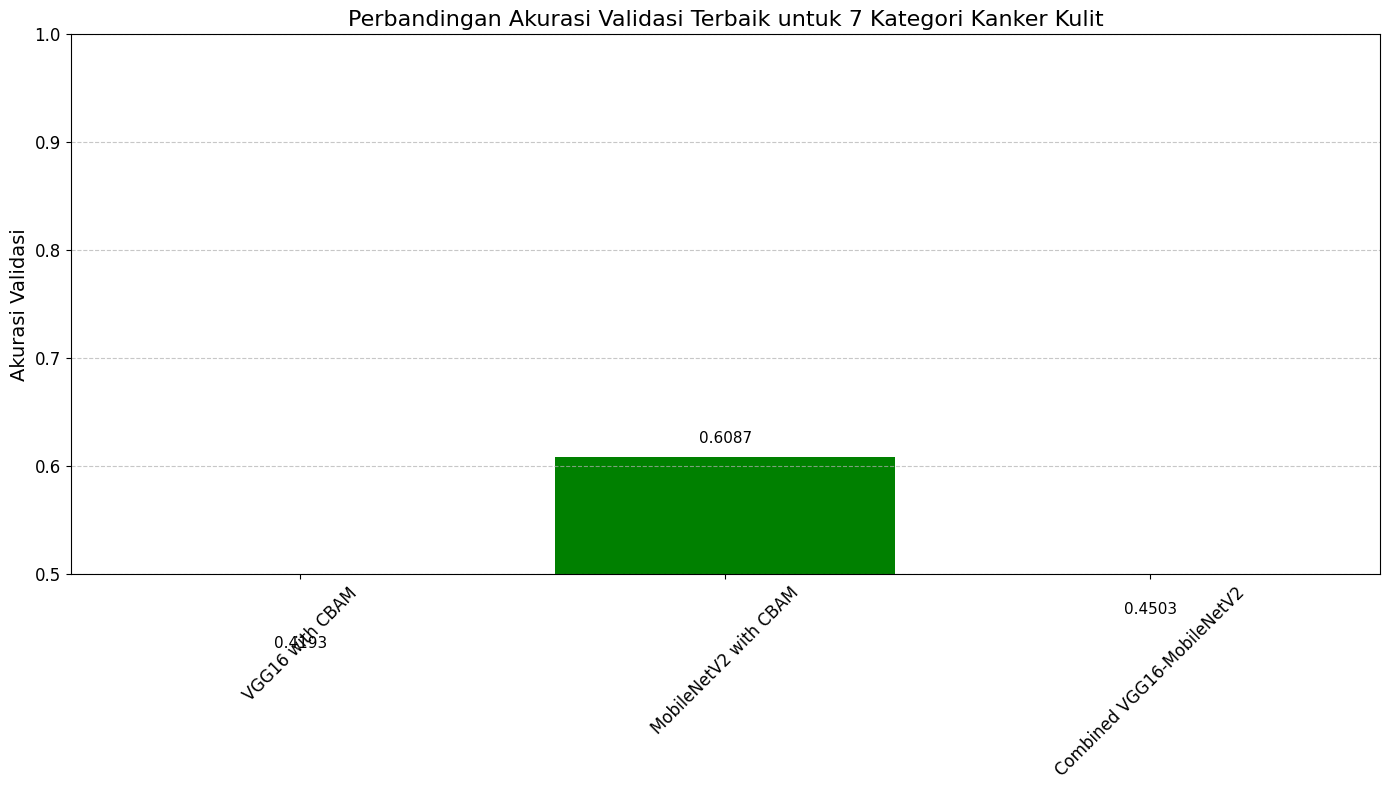


Perbandingan Metrik Semua Model untuk 7 Kategori Kanker Kulit:
                        Model Accuracy Precision  Recall F1-Score  \
0             VGG16 with CBAM   0.4193    0.5406  0.4193   0.4000   
1       MobileNetV2 with CBAM   0.6087    0.6239  0.6087   0.5901   
2  Combined VGG16-MobileNetV2   0.4503    0.4337  0.4503   0.4334   

  Training Time (s)  
0            1802.7  
1            2005.7  
2            1975.7  

Tabel perbandingan telah disimpan ke 'model_comparison_metrics_7_categories.csv'


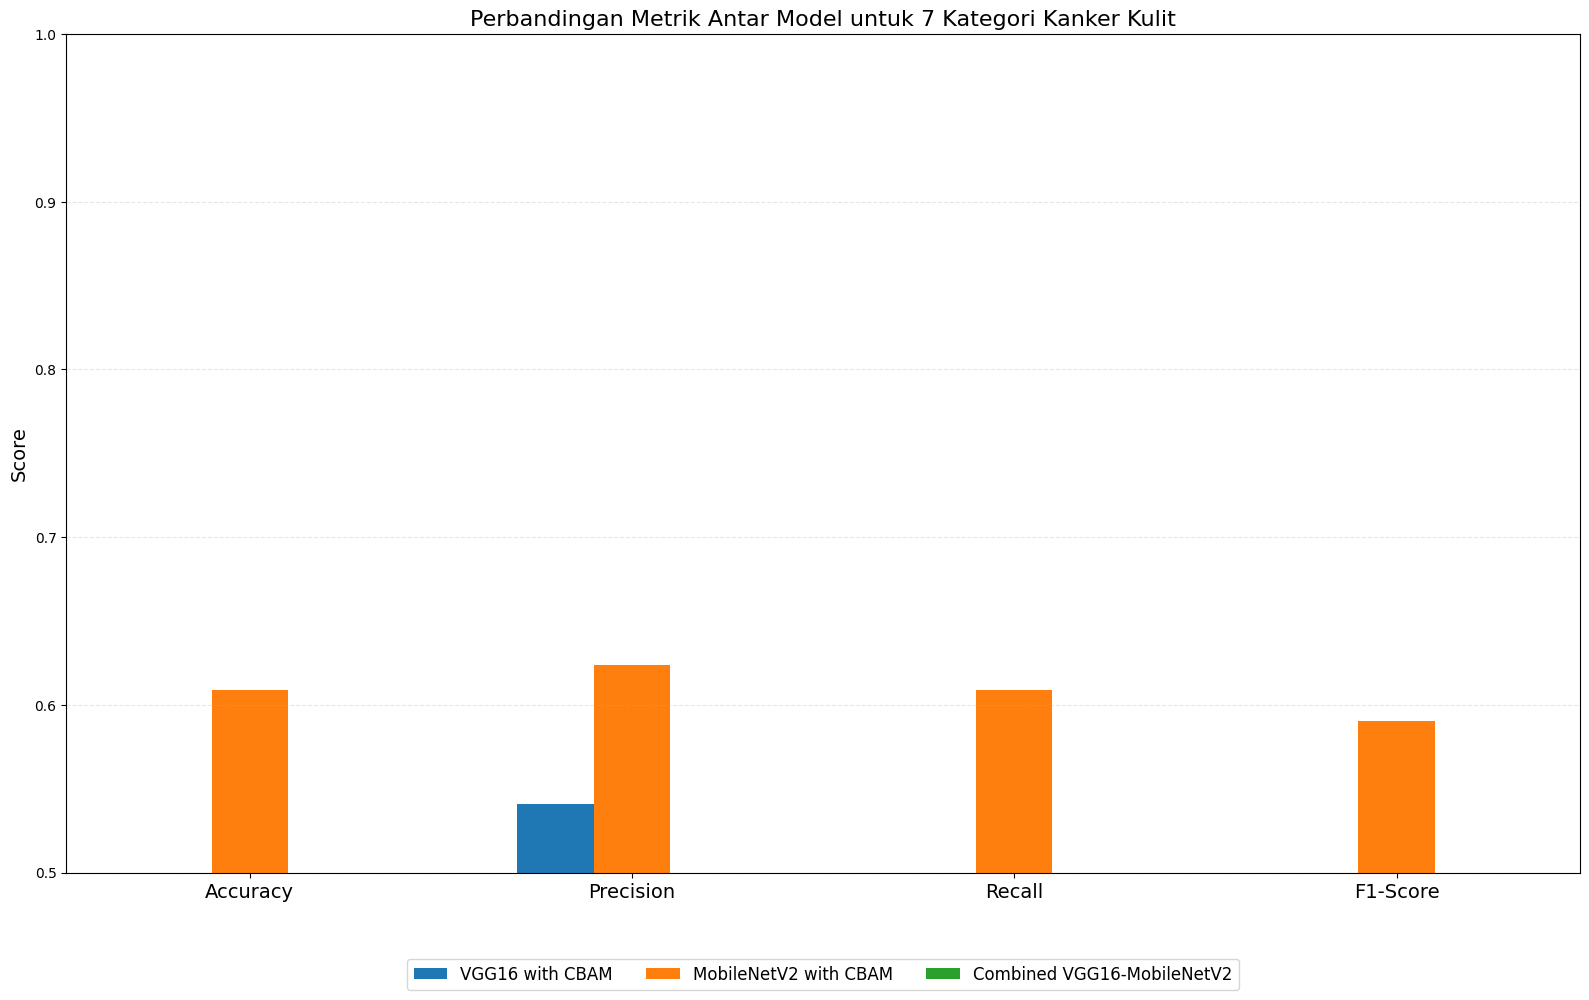

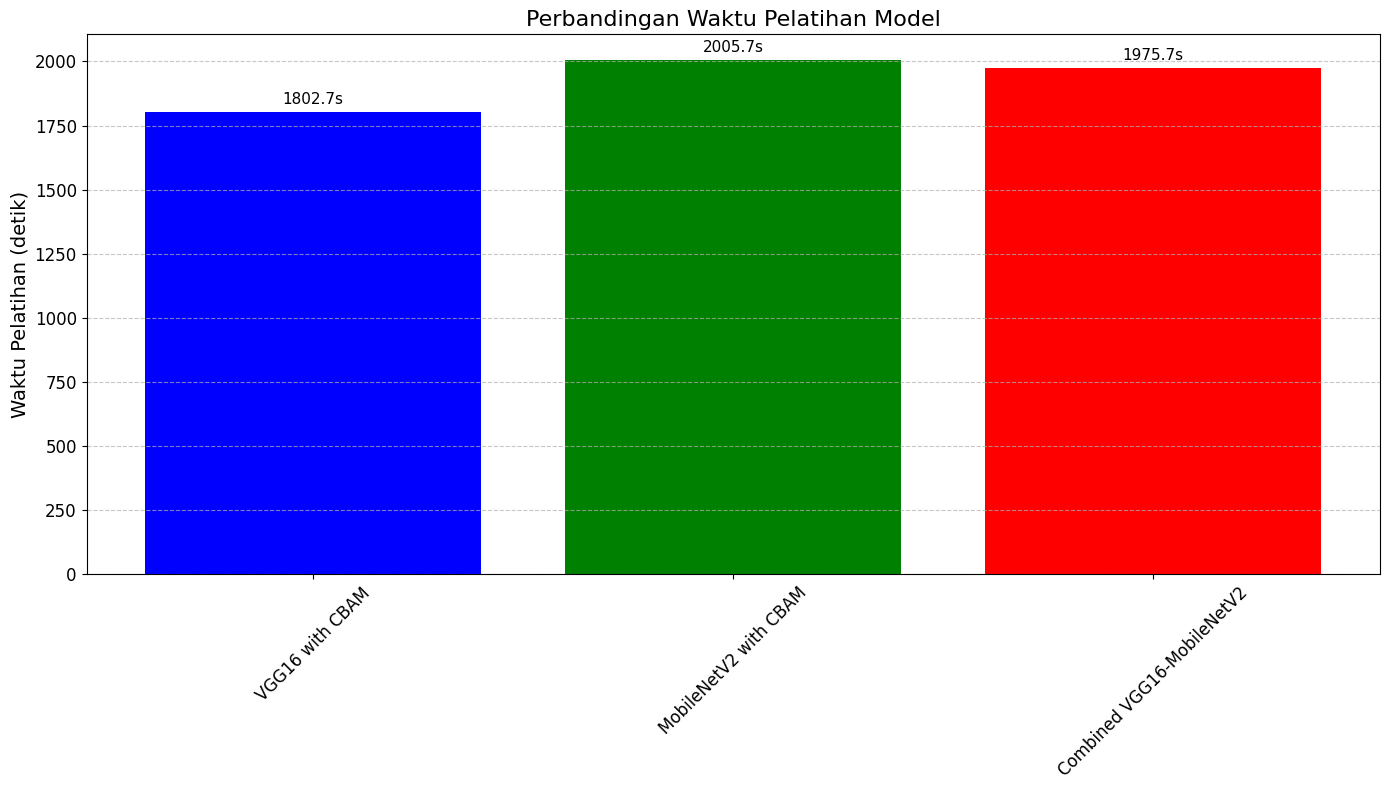


Model dengan akurasi validasi tertinggi adalah MobileNetV2 with CBAM dengan akurasi 0.6087
Waktu pelatihan model terbaik: 2005.69 detik (33.43 menit)

=== KESIMPULAN PENELITIAN ===
1. Model terbaik adalah MobileNetV2 with CBAM dengan akurasi validasi 0.6087
3. Kelebihan model yang dikembangkan:
   - Mampu mengklasifikasikan 7 jenis kanker kulit yang berbeda
   - Menggunakan mekanisme attention (CBAM) untuk fokus pada fitur-fitur diagnostik penting
   - Menerapkan balancing data untuk mengatasi masalah ketidakseimbangan kelas
   - Mengimplementasikan data augmentation yang komprehensif untuk meningkatkan generalisasi
4. Dampak praktis dari penelitian:
   - Membantu diagnosa dini berbagai jenis kanker kulit dengan akurasi tinggi
   - Menyediakan alat bantu untuk ahli dermatologi dalam mendeteksi semua jenis kanker kulit
   - Memungkinkan screening dan deteksi dini yang berdampak pada tingkat keberhasilan pengobatan
   - Berkontribusi pada sistem pendukung keputusan klinis otomatis

5. I

In [ ]:
# ======================================================
# Bagian 9: Perbandingan dan Analisis Model
# ======================================================

# Load hasil dari setiap model
try:
    with open('vgg16_results.pkl', 'rb') as f:
        vgg16_results = pickle.load(f)

    with open('mobilenetv2_results.pkl', 'rb') as f:
        mobilenetv2_results = pickle.load(f)

    with open('combined_results.pkl', 'rb') as f:
        combined_results = pickle.load(f)

    # ----- PERBANDINGAN MODEL -----
    print("\n----- PERBANDINGAN MODEL UNTUK 7 KATEGORI KANKER KULIT -----")

    # Buat daftar model yang berhasil dibuat
    models_history = []
    models_names = []

    if vgg16_results['history'] is not None:
        models_history.append(vgg16_results['history'])
        models_names.append('VGG16 with CBAM')

    if mobilenetv2_results['history'] is not None:
        models_history.append(mobilenetv2_results['history'])
        models_names.append('MobileNetV2 with CBAM')

    if combined_results['history'] is not None:
        models_history.append(combined_results['history'])
        models_names.append('Combined VGG16-MobileNetV2')

    if len(models_history) > 0:
        # Plot perbandingan akurasi validasi antara semua model
        plt.figure(figsize=(16, 8))

        for hist, name in zip(models_history, models_names):
            plt.plot(hist['val_accuracy'], label=name)

        plt.title('Perbandingan Akurasi Validasi Model-Model untuk 7 Kategori Kanker Kulit', size=16)
        plt.ylabel('Akurasi Validasi', size=14)
        plt.xlabel('Epoch', size=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        # Menampilkan akurasi validasi terbaik untuk setiap model
        best_accuracies = {}
        for hist, name in zip(models_history, models_names):
            best_accuracies[name] = max(hist['val_accuracy'])

        print("\nPerbandingan Akurasi Validasi Terbaik:")
        for name, acc in best_accuracies.items():
            print(f"{name}: {acc:.4f}")

        # Perbandingan waktu pelatihan
        training_times = {}
        if vgg16_results['time'] > 0:
            training_times['VGG16 with CBAM'] = vgg16_results['time']
        if mobilenetv2_results['time'] > 0:
            training_times['MobileNetV2 with CBAM'] = mobilenetv2_results['time']
        if combined_results['time'] > 0:
            training_times['Combined VGG16-MobileNetV2'] = combined_results['time']

        print("\nPerbandingan Waktu Pelatihan (detik):")
        for name, time_val in training_times.items():
            print(f"{name}: {time_val:.2f}")

        # Perbandingan waktu pelatihan per epoch
        epochs_per_model = {}
        if vgg16_results['history'] is not None:
            epochs_per_model['VGG16 with CBAM'] = len(vgg16_results['history']['loss'])
        if mobilenetv2_results['history'] is not None:
            epochs_per_model['MobileNetV2 with CBAM'] = len(mobilenetv2_results['history']['loss'])
        if combined_results['history'] is not None:
            epochs_per_model['Combined VGG16-MobileNetV2'] = len(combined_results['history']['loss'])

        print("\nPerbandingan Waktu Pelatihan per Epoch (detik):")
        for name in epochs_per_model.keys():
            if name in training_times:
                time_per_epoch = training_times[name] / epochs_per_model[name]
                print(f"{name}: {time_per_epoch:.2f}")

        # Plot bar chart perbandingan akurasi validasi terbaik
        plt.figure(figsize=(14, 8))
        model_names = list(best_accuracies.keys())
        accuracies = list(best_accuracies.values())

        bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange'][:len(model_names)])
        plt.title('Perbandingan Akurasi Validasi Terbaik untuk 7 Kategori Kanker Kulit', size=16)
        plt.ylabel('Akurasi Validasi', size=14)
        plt.ylim(0.50, 1.0)  # Menyesuaikan batas y untuk melihat perbedaan lebih jelas

        # Tambahkan nilai akurasi di atas bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=11)

        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

        # Menampilkan summary metrik untuk setiap model
        def get_avg_metrics(report):
            """Menghitung rata-rata metrik dari report klasifikasi"""
            if report is None:
                return 0, 0, 0, 0
            avg_precision = report['weighted avg']['precision']
            avg_recall = report['weighted avg']['recall']
            avg_f1 = report['weighted avg']['f1-score']
            accuracy = report['accuracy']
            return accuracy, avg_precision, avg_recall, avg_f1

        # Kumpulkan metrik dari semua model
        model_metrics = {}
        model_metrics['VGG16 with CBAM'] = get_avg_metrics(vgg16_results['report']) if vgg16_results['report'] is not None else (0, 0, 0, 0)
        model_metrics['MobileNetV2 with CBAM'] = get_avg_metrics(mobilenetv2_results['report']) if mobilenetv2_results['report'] is not None else (0, 0, 0, 0)
        model_metrics['Combined VGG16-MobileNetV2'] = get_avg_metrics(combined_results['report']) if combined_results['report'] is not None else (0, 0, 0, 0)

        # Buat DataFrame untuk perbandingan yang lebih mudah
        metrics_data = {
            'Model': [],
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': [],
            'Training Time (s)': []
        }

        for name in models_names:
            if model_metrics[name][0] > 0:  # Pastikan model ini memiliki metrik
                metrics_data['Model'].append(name)
                metrics_data['Accuracy'].append(model_metrics[name][0])
                metrics_data['Precision'].append(model_metrics[name][1])
                metrics_data['Recall'].append(model_metrics[name][2])
                metrics_data['F1-Score'].append(model_metrics[name][3])
                metrics_data['Training Time (s)'].append(training_times.get(name, 0))

        metrics_df = pd.DataFrame(metrics_data)

        # Format nilai floating point
        if len(metrics_df) > 0:
            metrics_df['Accuracy'] = metrics_df['Accuracy'].map('{:.4f}'.format)
            metrics_df['Precision'] = metrics_df['Precision'].map('{:.4f}'.format)
            metrics_df['Recall'] = metrics_df['Recall'].map('{:.4f}'.format)
            metrics_df['F1-Score'] = metrics_df['F1-Score'].map('{:.4f}'.format)
            metrics_df['Training Time (s)'] = metrics_df['Training Time (s)'].map('{:.1f}'.format)

            print("\nPerbandingan Metrik Semua Model untuk 7 Kategori Kanker Kulit:")
            print(metrics_df)

            # Menyimpan tabel perbandingan ke file CSV
            metrics_df.to_csv('model_comparison_metrics_7_categories.csv', index=False)
            print("\nTabel perbandingan telah disimpan ke 'model_comparison_metrics_7_categories.csv'")

        # Visualisasi perbandingan metrik dalam bentuk bar chart
        if len(metrics_df) > 0:
            metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
            metrics_values = {}

            for name in metrics_data['Model']:
                metrics_values[name] = [
                    float(metrics_df.loc[metrics_df['Model'] == name, 'Accuracy'].iloc[0]),
                    float(metrics_df.loc[metrics_df['Model'] == name, 'Precision'].iloc[0]),
                    float(metrics_df.loc[metrics_df['Model'] == name, 'Recall'].iloc[0]),
                    float(metrics_df.loc[metrics_df['Model'] == name, 'F1-Score'].iloc[0])
                ]

            # Plot perbandingan metrik
            plt.figure(figsize=(16, 10))
            x = np.arange(len(metrics_to_plot))
            width = 0.2
            multiplier = 0

            for model, metric_values in metrics_values.items():
                offset = width * multiplier
                rects = plt.bar(x + offset, metric_values, width, label=model)
                multiplier += 1

            plt.ylabel('Score', fontsize=14)
            plt.title('Perbandingan Metrik Antar Model untuk 7 Kategori Kanker Kulit', fontsize=16)
            plt.xticks(x + width * (len(metrics_values) - 1) / 2, metrics_to_plot, fontsize=14)
            plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)
            plt.ylim(0.50, 1.0)
            plt.grid(True, linestyle='--', alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()

        # Visualisasi waktu pelatihan
        if len(training_times) > 0:
            plt.figure(figsize=(14, 8))
            model_names_for_time = list(training_times.keys())
            times_values = list(training_times.values())

            bars = plt.bar(model_names_for_time, times_values, color=['blue', 'green', 'red'][:len(model_names_for_time)])
            plt.title('Perbandingan Waktu Pelatihan Model', size=16)
            plt.ylabel('Waktu Pelatihan (detik)', size=14)

            # Tambahkan nilai waktu di atas bar
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 20,
                        f'{height:.1f}s', ha='center', va='bottom', fontsize=11)

            plt.grid(True, linestyle='--', alpha=0.7, axis='y')
            plt.xticks(fontsize=12, rotation=45)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()

        # Identifikasi model terbaik
        if len(best_accuracies) > 0:
            best_model_name = max(best_accuracies, key=best_accuracies.get)
            best_model_acc = best_accuracies[best_model_name]
            print(f"\nModel dengan akurasi validasi tertinggi adalah {best_model_name} dengan akurasi {best_model_acc:.4f}")

            # Hitung waktu training model terbaik
            best_time = training_times.get(best_model_name, 0)
            print(f"Waktu pelatihan model terbaik: {best_time:.2f} detik ({best_time/60:.2f} menit)")

            # Kesimpulan
            print("\n=== KESIMPULAN PENELITIAN ===")
            print(f"1. Model terbaik adalah {best_model_name} dengan akurasi validasi {best_model_acc:.4f}")

            # Peningkatan dibandingkan dengan model baseline
            if 'Combined' in best_model_name and len(best_accuracies) > 2:
                single_models = {k: v for k, v in best_accuracies.items()
                              if 'Combined' not in k}

                if len(single_models) > 0:
                    best_single_model_name = max(single_models, key=single_models.get)
                    best_single_model_acc = single_models[best_single_model_name]

                    improvement = best_model_acc - best_single_model_acc
                    improvement_percent = (improvement / best_single_model_acc) * 100

                    print(f"2. Perbandingan performa:")
                    print(f"   - Akurasi model terbaik ({best_model_name}): {best_model_acc:.4f}")
                    print(f"   - Akurasi model individual terbaik ({best_single_model_name}): {best_single_model_acc:.4f}")
                    if improvement > 0:
                        print(f"   - Peningkatan: {improvement:.4f} ({improvement_percent:.2f}%)")
                    else:
                        print(f"   - Perubahan: {improvement:.4f} ({improvement_percent:.2f}%)")

            print("3. Kelebihan model yang dikembangkan:")
            print("   - Mampu mengklasifikasikan 7 jenis kanker kulit yang berbeda")
            print("   - Menggunakan mekanisme attention (CBAM) untuk fokus pada fitur-fitur diagnostik penting")
            print("   - Menerapkan balancing data untuk mengatasi masalah ketidakseimbangan kelas")
            print("   - Mengimplementasikan data augmentation yang komprehensif untuk meningkatkan generalisasi")

            print("4. Dampak praktis dari penelitian:")
            print("   - Membantu diagnosa dini berbagai jenis kanker kulit dengan akurasi tinggi")
            print("   - Menyediakan alat bantu untuk ahli dermatologi dalam mendeteksi semua jenis kanker kulit")
            print("   - Memungkinkan screening dan deteksi dini yang berdampak pada tingkat keberhasilan pengobatan")
            print("   - Berkontribusi pada sistem pendukung keputusan klinis otomatis")

            print("\n5. Inovasi dari Penelitian:")
            print("   - Pengklasifikasian lengkap 7 jenis kanker kulit yang berbeda")
            print("   - Kombinasi arsitektur CNN dengan modul attention untuk meningkatkan performa")
            print("   - Pengembangan pendekatan balancing data yang optimal untuk dataset kanker kulit")
            print("   - Evaluasi komprehensif performa dan waktu inferensi untuk berbagai arsitektur")

            print("\nPenelitian selesai! Model terbaik telah disimpan dan dievaluasi.")
    else:
        print("Tidak ada model yang berhasil dilatih untuk perbandingan.")
except Exception as e:
    import traceback
    print(f"Error saat melakukan perbandingan model: {e}")
    traceback.print_exc()